# Entity Resolution project @ Wavestone
## Entity Matching

> *Datasets information from [here](https://data.dws.informatik.uni-mannheim.de/benchmarkmatchingtasks/index.html)*

> **Tristan PERROT**


## Run results

In [1]:
!python result_zero_shot.py

Using device: cuda:0
/home/infres/tperrot-21
2025-02-04 00:44:01.966992: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738626241.989165  396540 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738626241.995737  396540 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-04 00:44:02.018598: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Models:   0%|                                             | 0/2 [00:00<?, ?it/s]

## Import libraries

In [1]:
import os

while 'model' not in os.listdir():
    os.chdir('..')

In [2]:
import re
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

from model.utils import load_data
import src.zero_shot.result_zero_shot as result_zero_shot
import src.import_data as import_data

Using device: cpu


/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print('Available models:')
print(result_zero_shot.MODELS)
print()
print('Available datasets:')
print(result_zero_shot.DATA_NAMES)

Available models:
['all-mpnet-base-v2', 'sentence-transformers/multi-qa-mpnet-base-dot-v1']

Available datasets:
['fodors-zagats', 'amazon-google', 'abt-buy']


In [4]:
preds = {}
results_dict = {}
for data_name in result_zero_shot.DATA_NAMES:
    results_dict[data_name] = {}
    table_a_serialized, table_b_serialized, X_train_ids, y_train, X_valid_ids, y_valid, X_test_ids, y_test = load_data(os.path.join(import_data.DATA_FOLDER, data_name))
    for model_name in result_zero_shot.MODELS:
        results_dict[data_name][model_name] = {}
        for order_cols in result_zero_shot.LOAD_OPTIONS['order_cols']:
            results_dict[data_name][model_name][order_cols] = {}
            for remove_col_names in result_zero_shot.LOAD_OPTIONS['remove_col_names']:
                dir_name = f'{data_name}-zshot/{model_name}-order_cols_{order_cols}-remove_col_names_{remove_col_names}'
                logits = pd.read_csv(os.path.join('results', dir_name, 'logits.csv'), names=['idA', 'idB', 'pred'])
                with open(os.path.join('results', dir_name, 'train_time.txt'), 'r') as file:
                    train_time = float(file.read().strip())
                results_dict[data_name][model_name][order_cols][remove_col_names] = {}
                results_dict[data_name][model_name][order_cols][remove_col_names]['precision'] = precision_score(y_test, logits['pred'].values > result_zero_shot.threshold)
                results_dict[data_name][model_name][order_cols][remove_col_names]['recall'] = recall_score(y_test, logits['pred'].values > result_zero_shot.threshold)
                results_dict[data_name][model_name][order_cols][remove_col_names]['f1'] = f1_score(y_test, logits['pred'].values > result_zero_shot.threshold)
                results_dict[data_name][model_name][order_cols][remove_col_names]['roc_auc'] = roc_auc_score(y_test, logits['pred'].values)
                results_dict[data_name][model_name][order_cols][remove_col_names]['accuracy'] = accuracy_score(y_test, logits['pred'].values > result_zero_shot.threshold)
                results_dict[data_name][model_name][order_cols][remove_col_names]['confusion_matrix'] = confusion_matrix(y_test, logits['pred'].values > result_zero_shot.threshold)
                fpr, tpr, _ = roc_curve(y_test, logits['pred'].values)
                results_dict[data_name][model_name][order_cols][remove_col_names]['roc_curve'] = (fpr, tpr, auc(fpr, tpr))
                results_dict[data_name][model_name][order_cols][remove_col_names]['logits'] = logits
                results_dict[data_name][model_name][order_cols][remove_col_names]['train_time'] = train_time
                

Table A columns:
  column_name              data_example
1        addr  '435 s. la cienega blv.'
2        city             'los angeles'
3       phone              310/246-1501
4        type                  american 

Table B columns:
  column_name           data_example
1        addr  '10801 w. pico blvd.'
2        city              'west la'
3       phone           310-475-3585
4        type               american 

Serialized entities 

Table A columns:
    column_name data_example
1   description          NaN
2  manufacturer   broderbund
3         price          0.0 

Table B columns:
    column_name              data_example
1   description  learning quickbooks 2007
2  manufacturer                    intuit
3         price                     38.99 

Serialized entities 

Table A columns:
   column_name                                       data_example
1  description  Sony Turntable - PSLX350H/ Belt Drive System/ ...
2        price                                                

In [5]:
for data_name, models in results_dict.items():
    best_f1 = 0
    best_option = None
    for model_name, orders in models.items():
        for order_cols, removes in orders.items():
            for remove_col_names, metrics in removes.items():
                if metrics['f1'] > best_f1:
                    best_f1 = metrics['f1']
                    best_option = (model_name, order_cols, remove_col_names)
    print(f"Dataset: {data_name}, Best F1 Score: {best_f1}, Options: {best_option}")

Dataset: fodors-zagats, Best F1 Score: 0.5945945945945946, Options: ('all-mpnet-base-v2', True, True)
Dataset: amazon-google, Best F1 Score: 0.6523076923076923, Options: ('all-mpnet-base-v2', False, False)
Dataset: abt-buy, Best F1 Score: 0.43103448275862066, Options: ('all-mpnet-base-v2', True, True)


In [6]:
for data_name, models in results_dict.items():
    for model_name, orders in models.items():
        for order_cols, removes in orders.items():
            for remove_col_names, metrics in removes.items():
                print(f"Dataset: {data_name}, Model: {model_name}, Order Cols: {order_cols}, Remove Col Names: {remove_col_names}")
                print(f"Precision: {metrics['precision']}")
                print(f"Recall: {metrics['recall']}")
                print(f"F1: {metrics['f1']}")
                print(f"ROC AUC: {metrics['roc_auc']}")
                print(f"Accuracy: {metrics['accuracy']}")
                print(f"Confusion Matrix: {metrics['confusion_matrix']}")
                print()

Dataset: fodors-zagats, Model: all-mpnet-base-v2, Order Cols: True, Remove Col Names: True
Precision: 0.4230769230769231
Recall: 1.0
F1: 0.5945945945945946
ROC AUC: 0.996694214876033
Accuracy: 0.7727272727272727
Confusion Matrix: [[40 15]
 [ 0 11]]

Dataset: fodors-zagats, Model: all-mpnet-base-v2, Order Cols: True, Remove Col Names: False
Precision: 0.22
Recall: 1.0
F1: 0.36065573770491804
ROC AUC: 0.971900826446281
Accuracy: 0.4090909090909091
Confusion Matrix: [[16 39]
 [ 0 11]]

Dataset: fodors-zagats, Model: all-mpnet-base-v2, Order Cols: False, Remove Col Names: True
Precision: 0.4074074074074074
Recall: 1.0
F1: 0.5789473684210527
ROC AUC: 0.9917355371900827
Accuracy: 0.7575757575757576
Confusion Matrix: [[39 16]
 [ 0 11]]

Dataset: fodors-zagats, Model: all-mpnet-base-v2, Order Cols: False, Remove Col Names: False
Precision: 0.20754716981132076
Recall: 1.0
F1: 0.34375
ROC AUC: 0.9636363636363636
Accuracy: 0.36363636363636365
Confusion Matrix: [[13 42]
 [ 0 11]]

Dataset: fodors-

## Visualisation

### 1. Bar Chart for Model Comparison

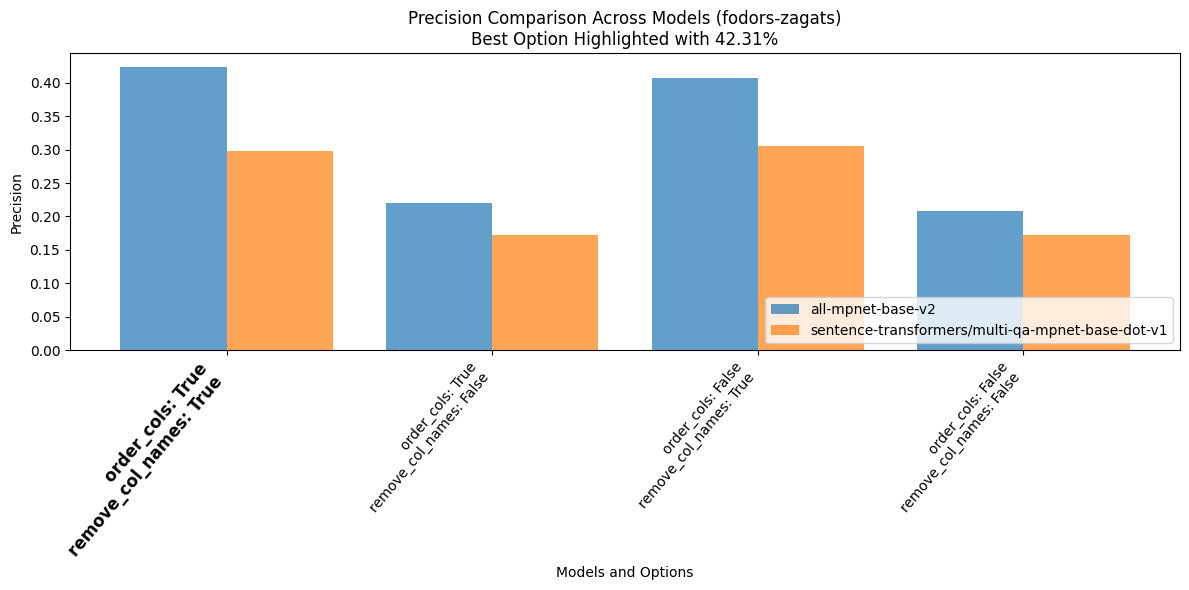

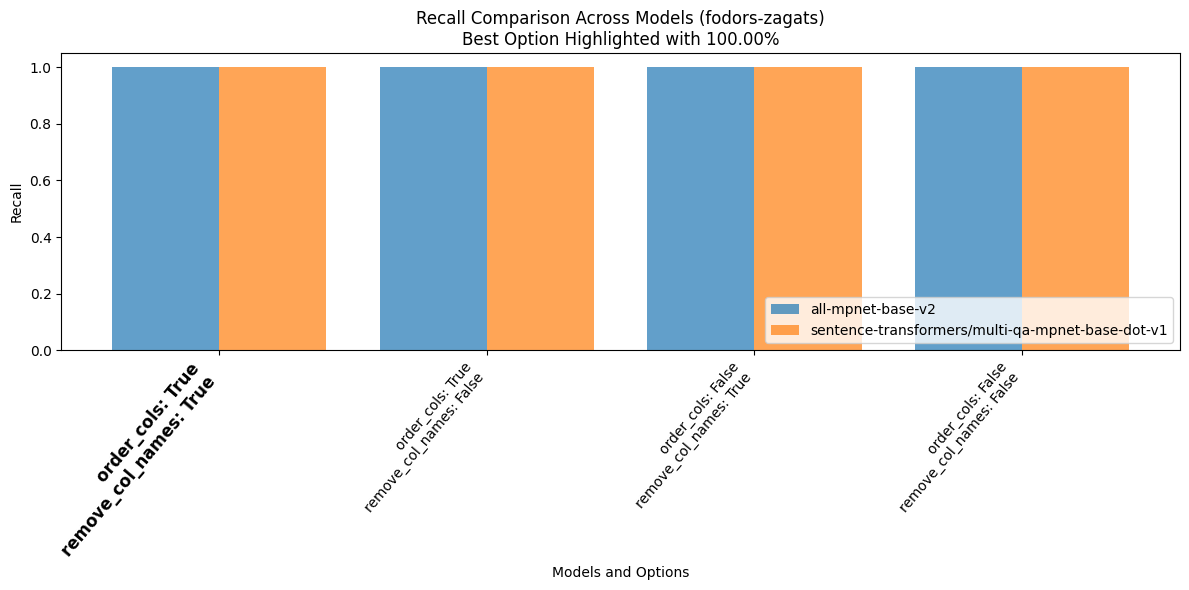

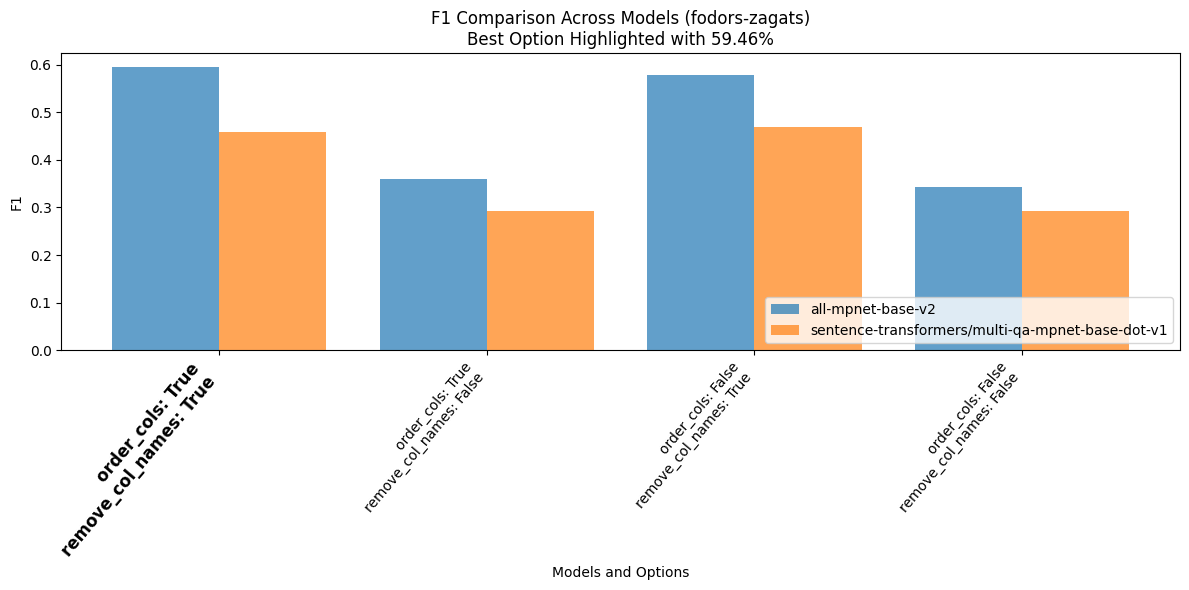

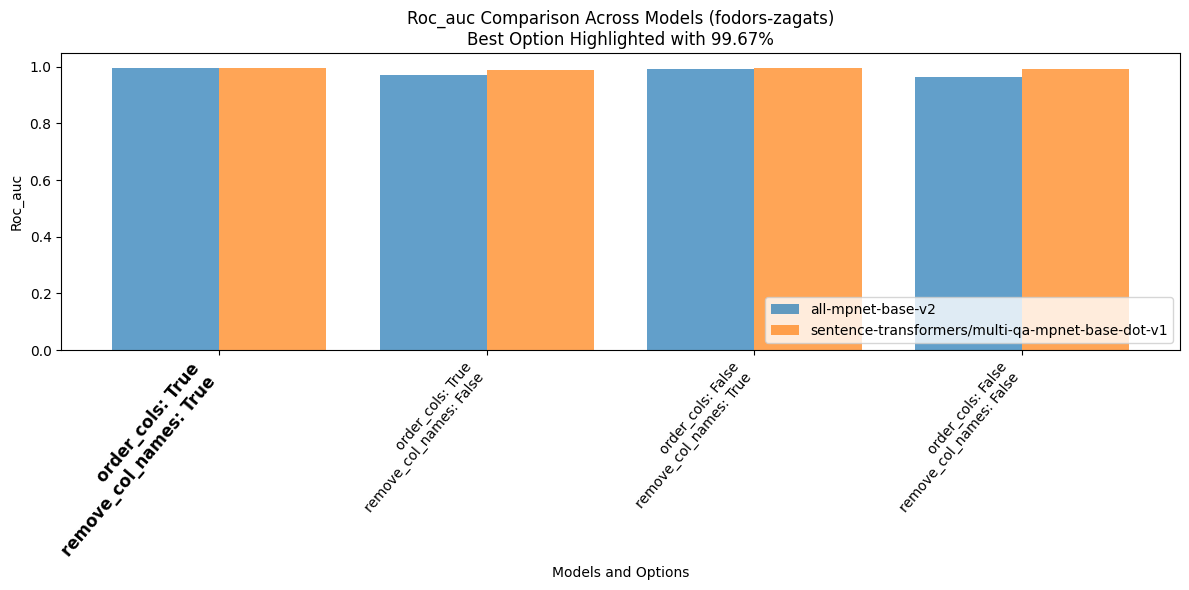

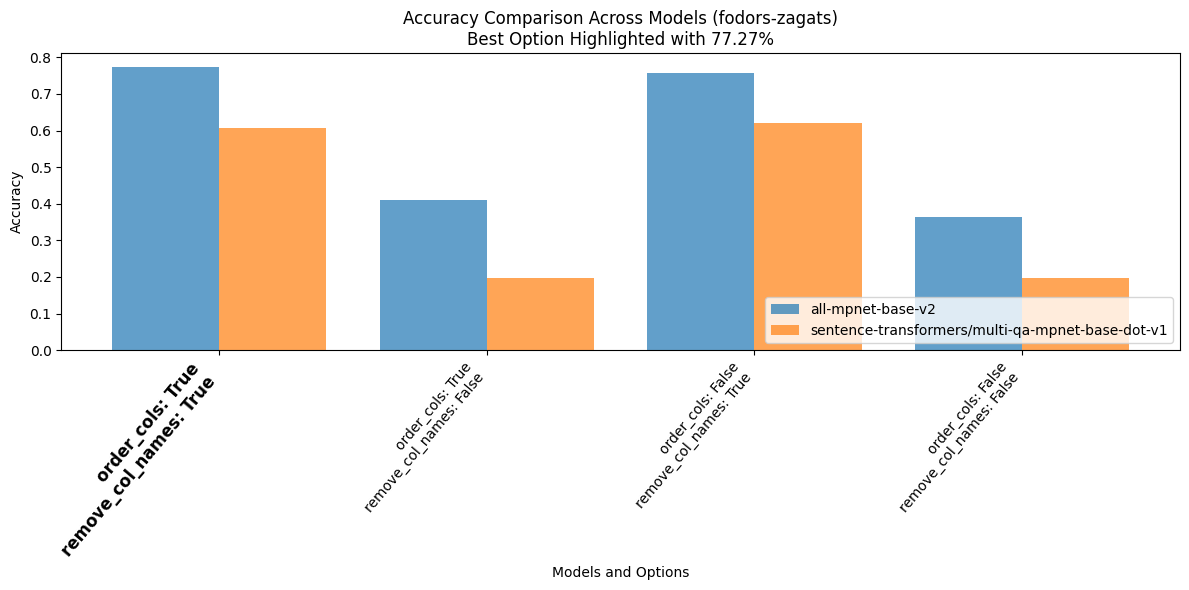

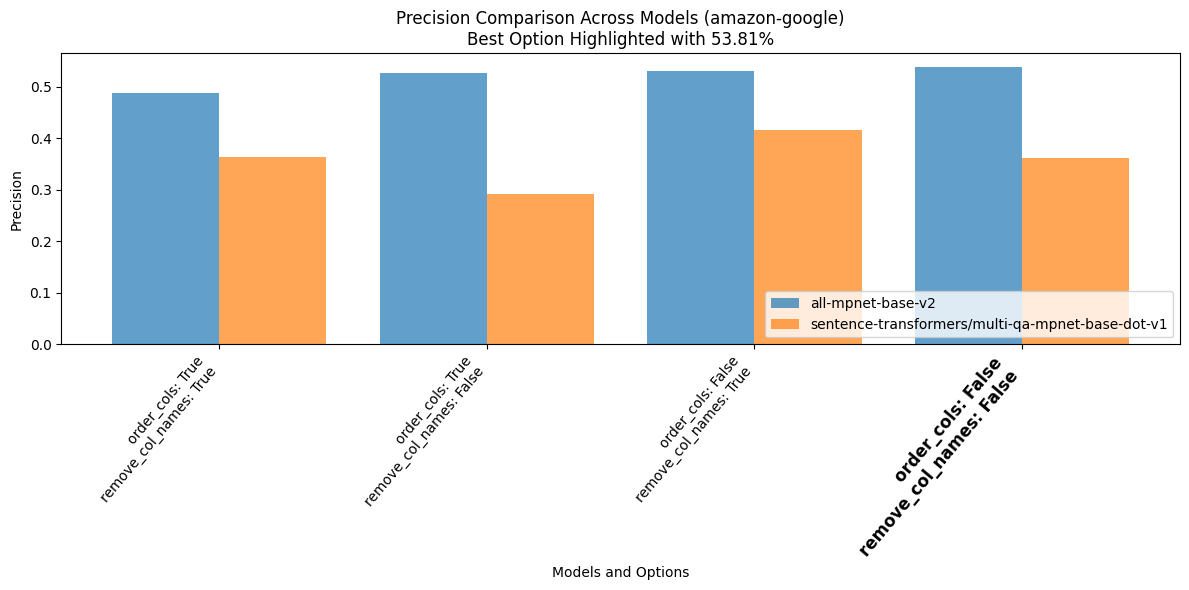

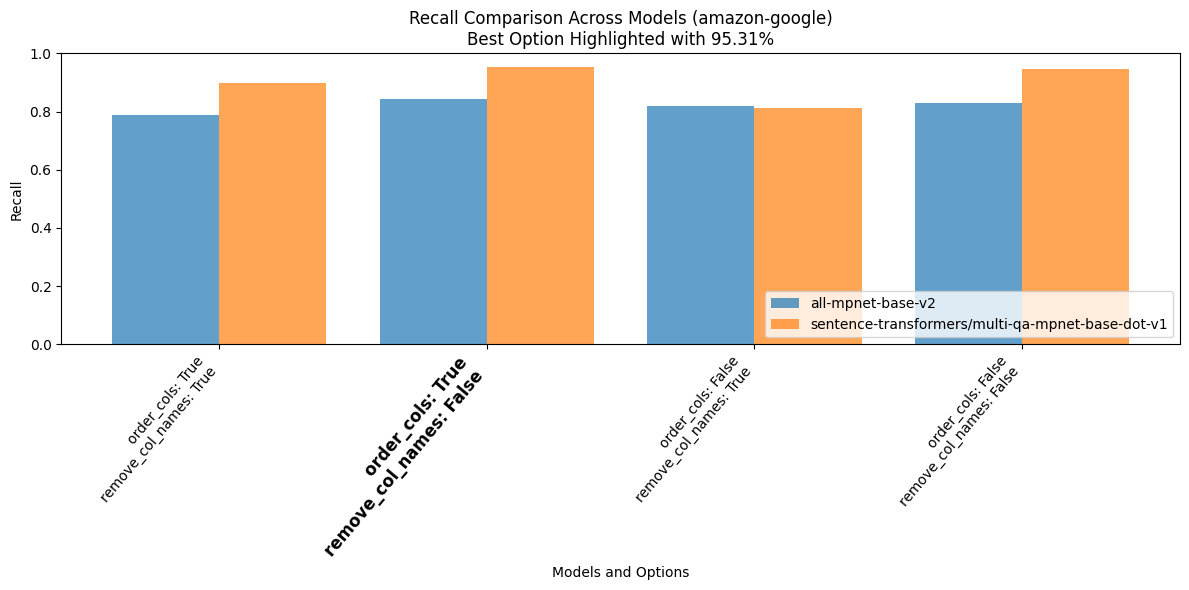

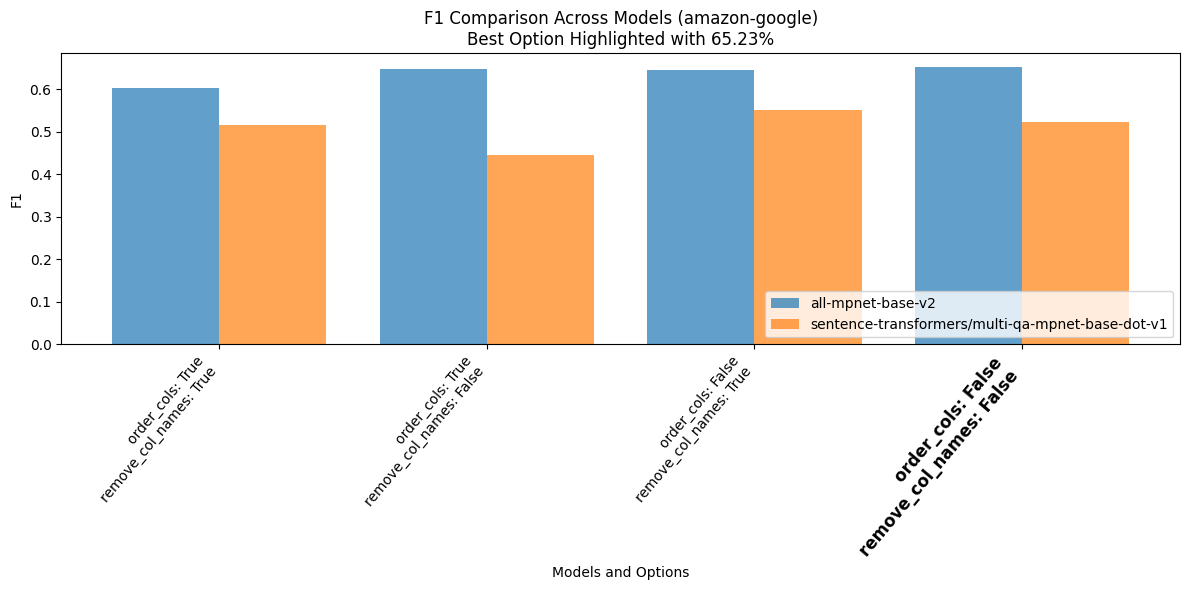

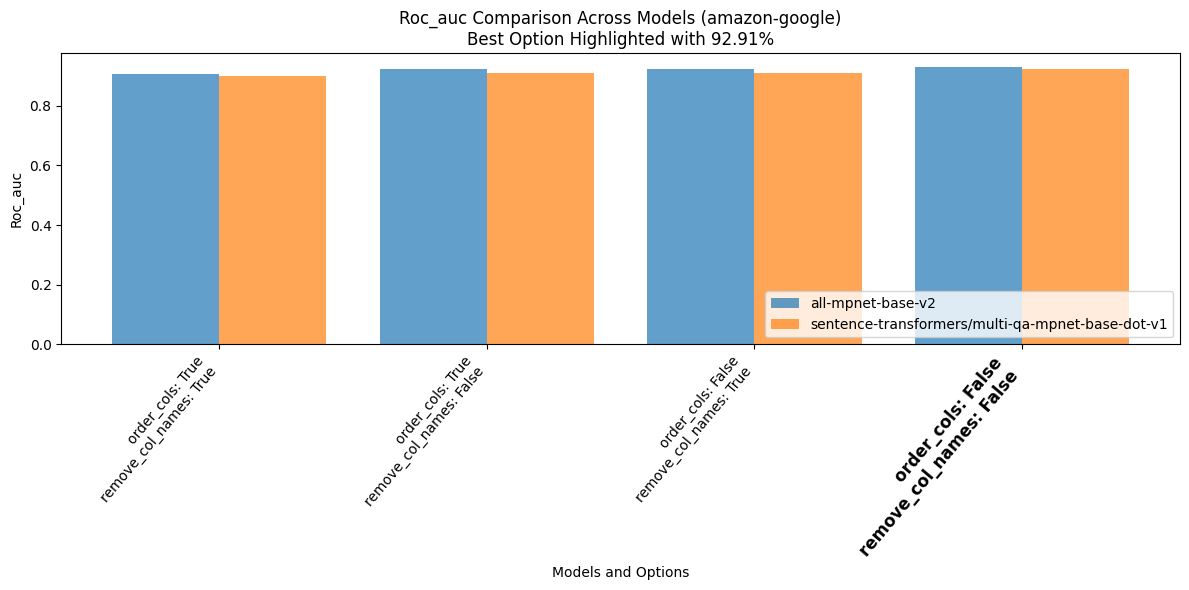

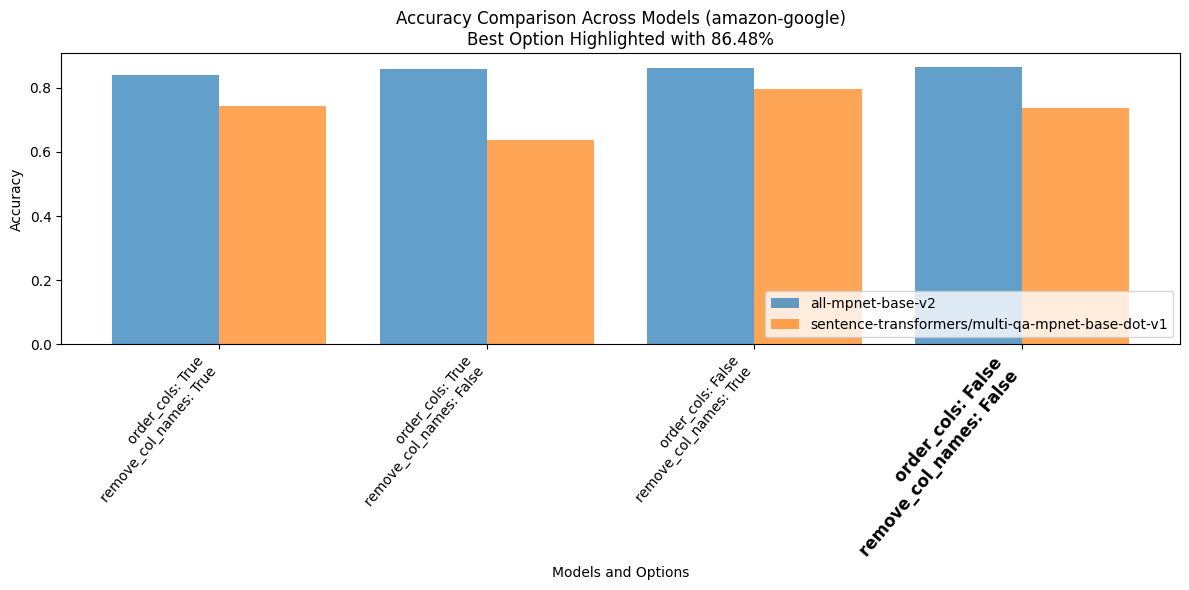

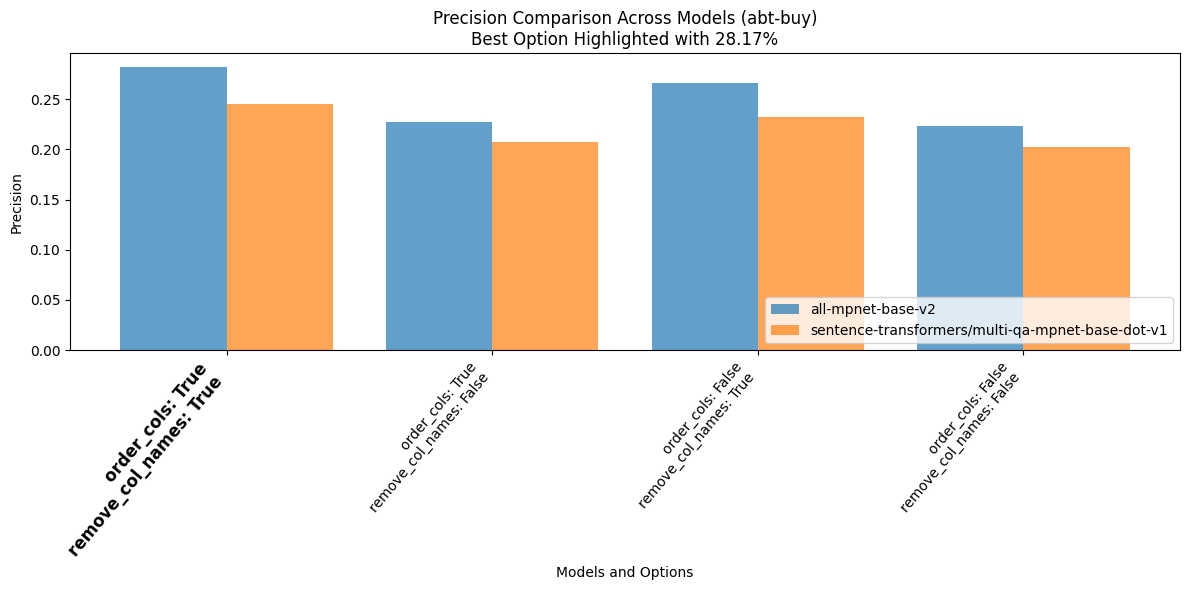

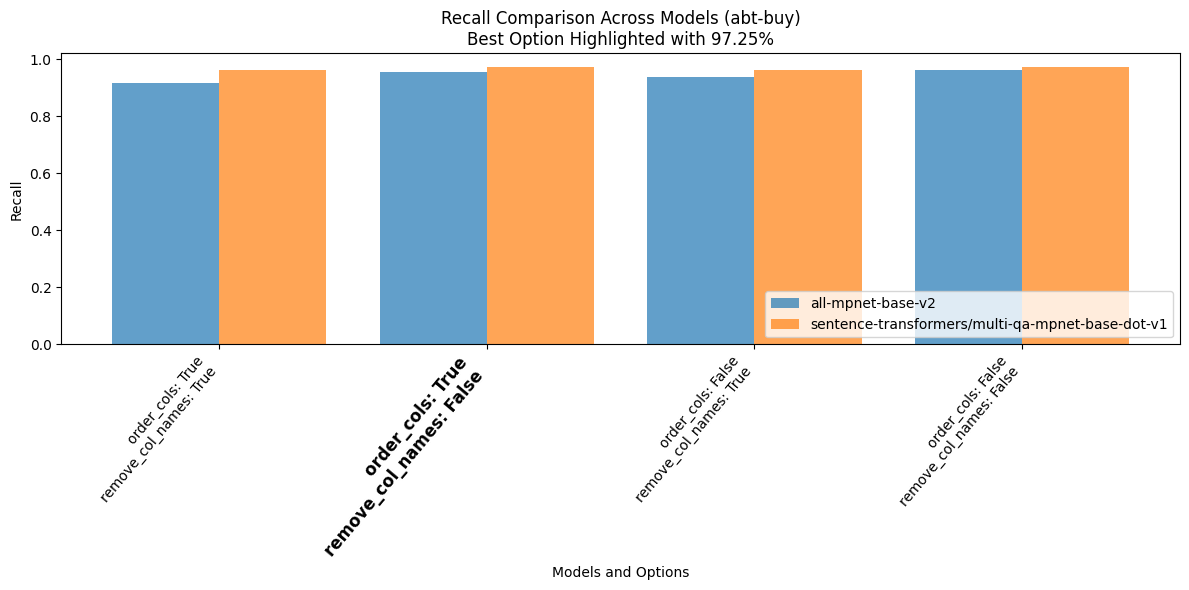

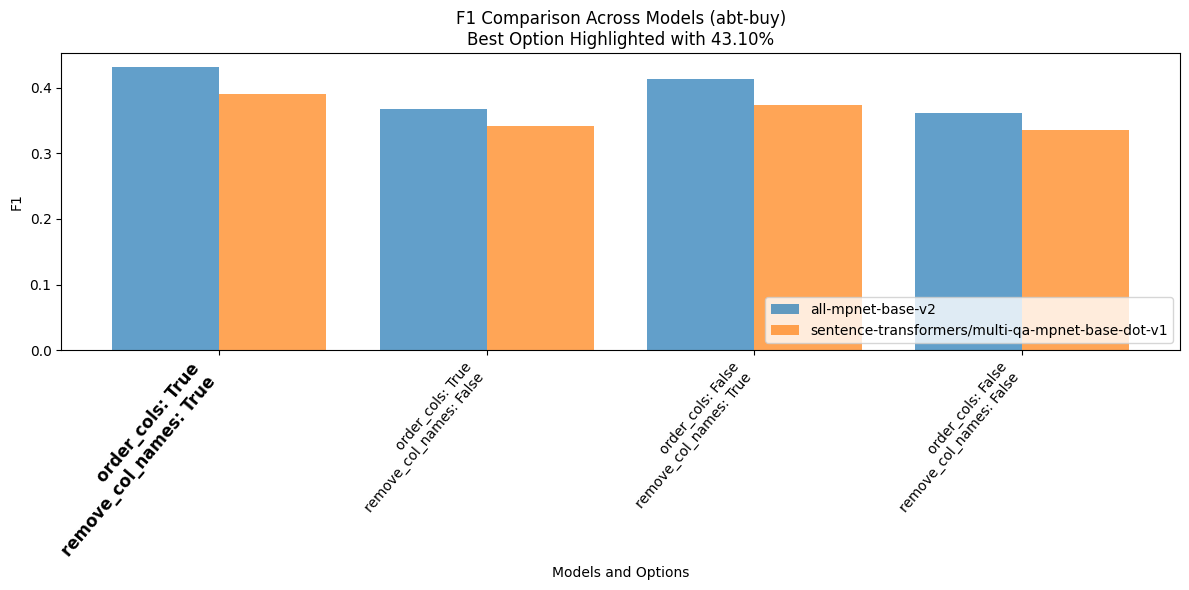

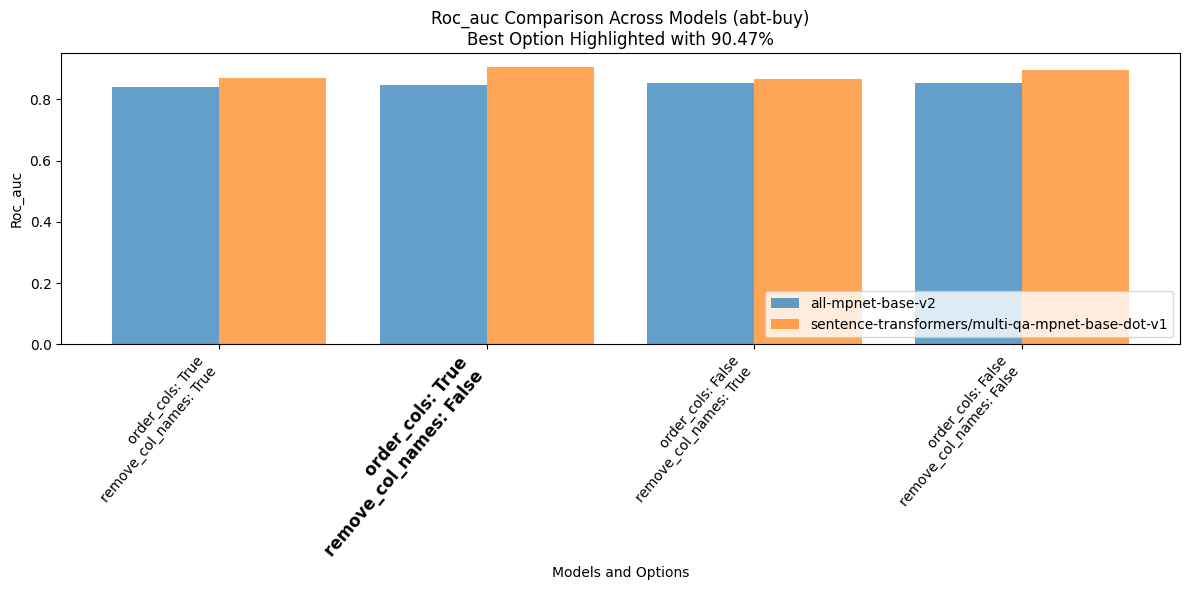

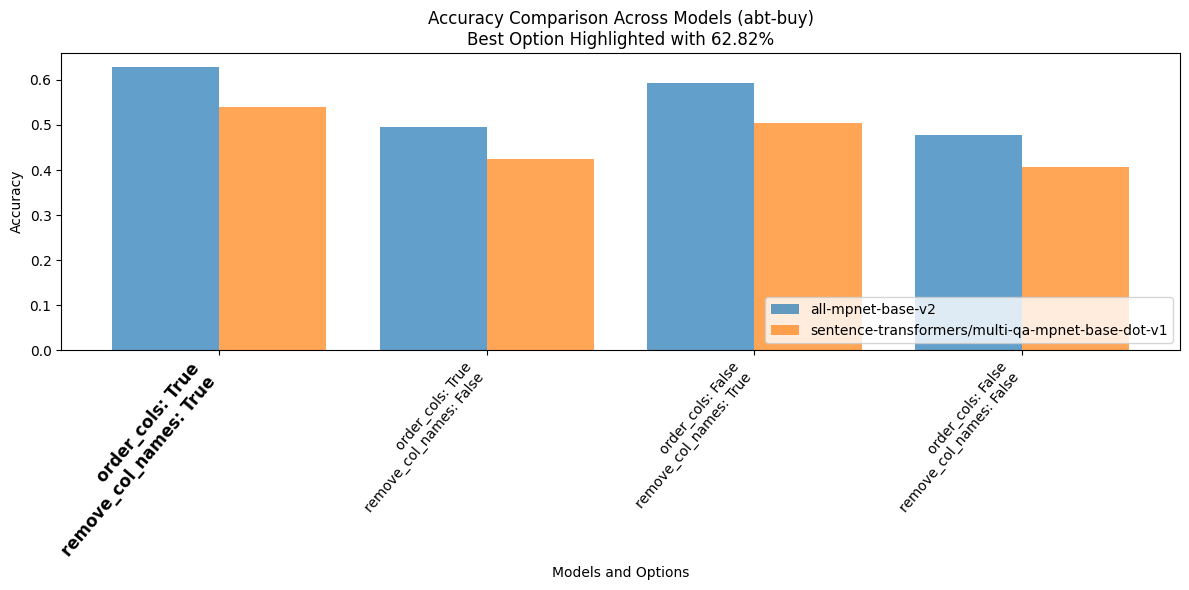

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting data
metrics_list = ['precision', 'recall', 'f1', 'roc_auc', 'accuracy']
datasets = results_dict.keys()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for data_name in datasets:
    for metric in metrics_list:
        fig, ax = plt.subplots(figsize=(12, 6))
        model_names = list(results_dict[data_name].keys())
        num_models = len(model_names)
        values = [[] for _ in range(num_models)]
        labels = []
        color_map = []
        for model_idx, model_name in enumerate(model_names):
            for order_cols in results_dict[data_name][model_name].keys():
                for remove_col_names in results_dict[data_name][model_name][order_cols].keys():
                    if model_idx == 0:
                        labels.append(f"order_cols: {order_cols}\nremove_col_names: {remove_col_names}")
                    values[model_idx].append(results_dict[data_name][model_name][order_cols][remove_col_names][metric])
                    color_map.append(colors[model_idx % len(colors)])
        
        x = np.arange(len(labels))
        bar_width = 0.8 / num_models  # Adjust the width of the bars
        for i in range(num_models):
            ax.bar(x + i * bar_width, values[i], bar_width, color=colors[i % len(colors)], alpha=0.7, label=model_names[i])
        
        ax.set_xticks(x + bar_width * (num_models - 1) / 2)
        ax.set_xticklabels(labels, rotation=50, ha='right')
        ax.set_title(f"{metric.capitalize()} Comparison Across Models ({data_name})\nBest Option Highlighted with {max(max(values)):.2%}")
        ax.set_xlabel("Models and Options")
        ax.set_ylabel(metric.capitalize())
        ax.legend(loc='lower right')
        
        # Highlight the best option
        best_option_idx = np.argmax([max(values[i]) for i in range(num_models)])
        best_label_idx = np.argmax(values[best_option_idx])
        ax.get_xticklabels()[best_label_idx].set_fontweight('bold')
        ax.get_xticklabels()[best_label_idx].set_fontsize(12)
        
        plt.tight_layout()
        plt.show()


### 2. Confusion Matrix Heatmap

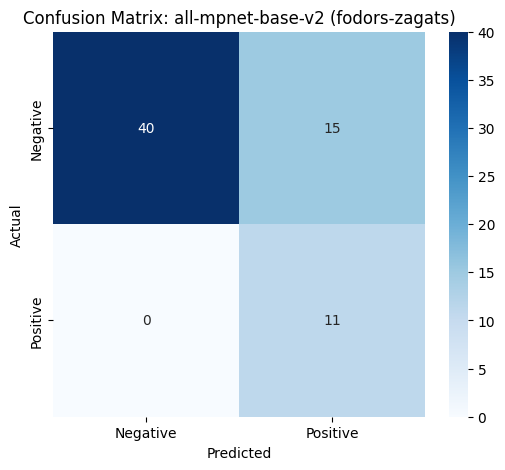

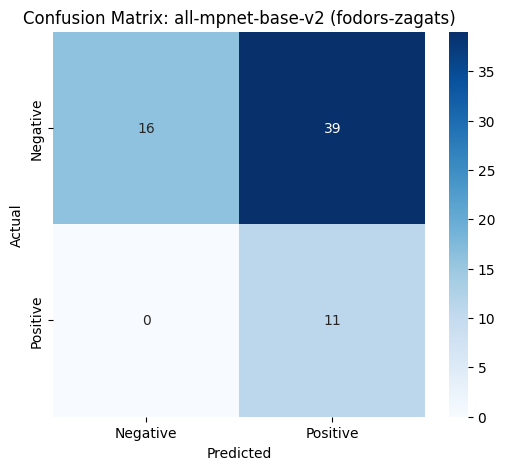

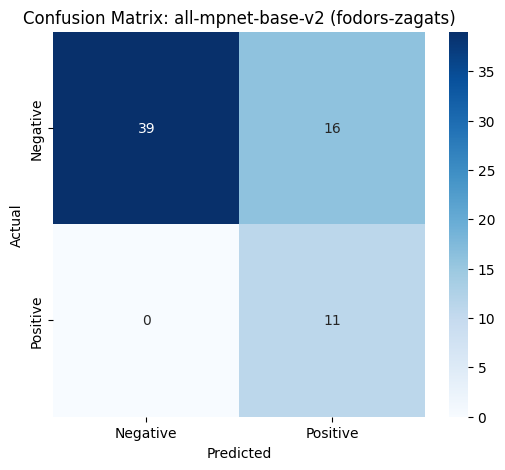

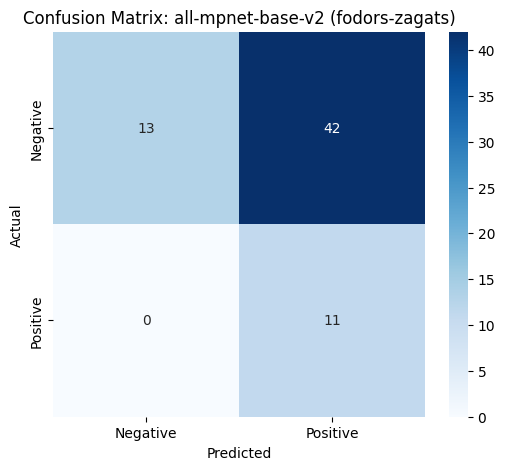

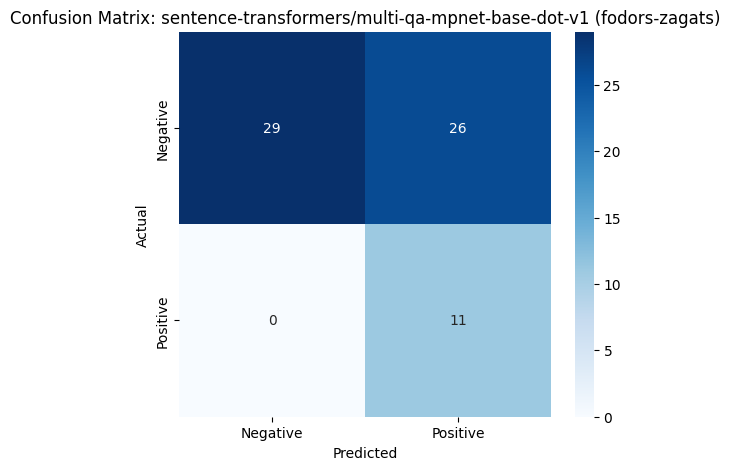

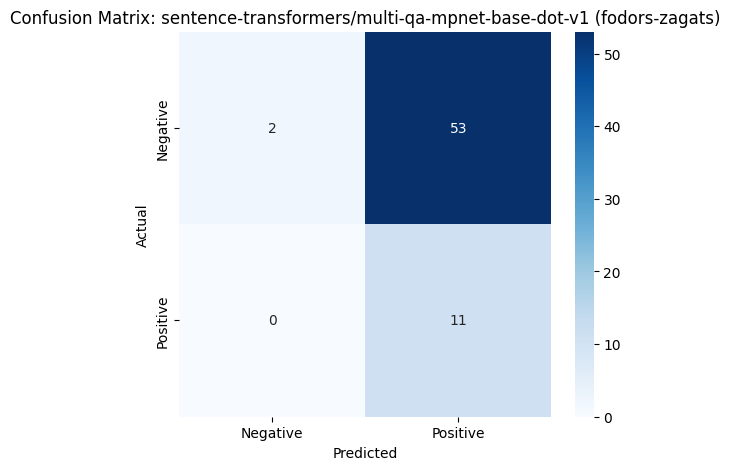

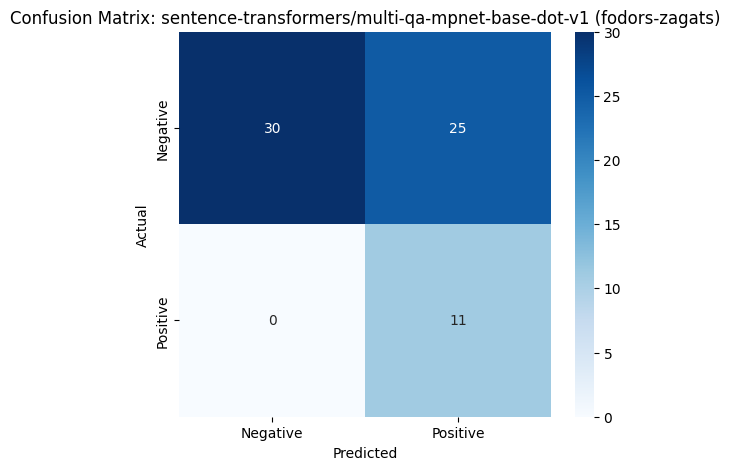

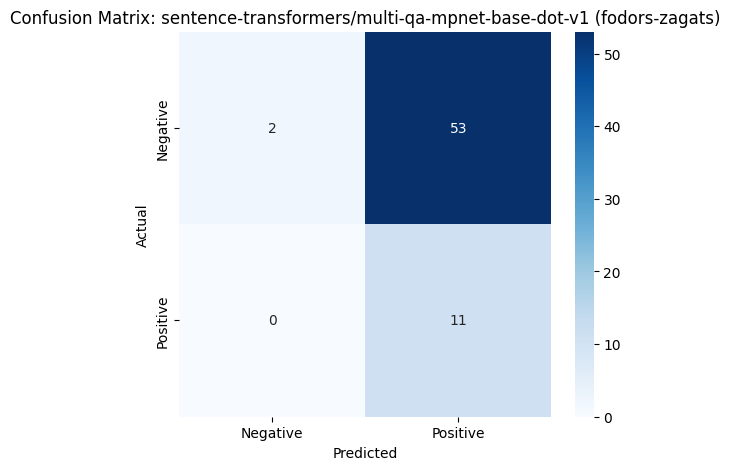

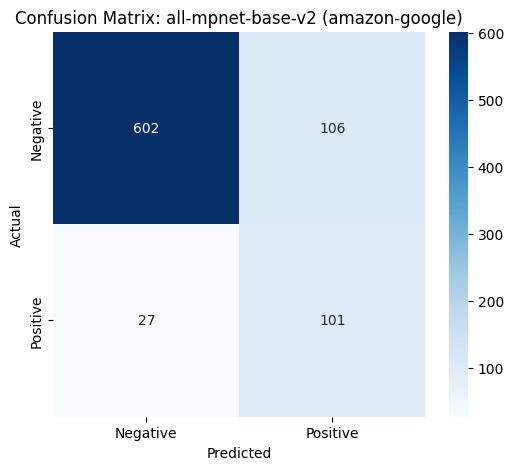

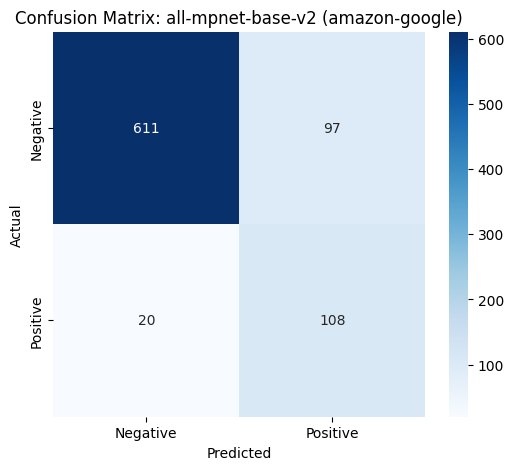

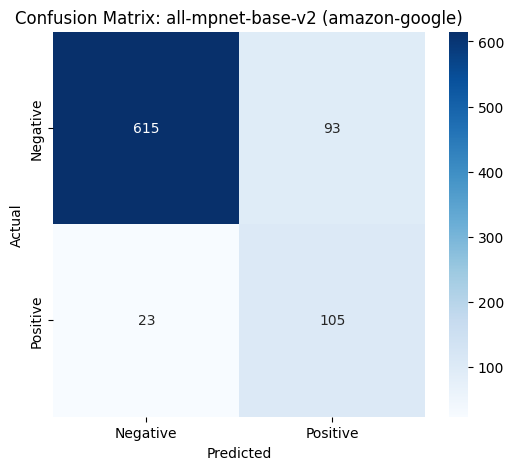

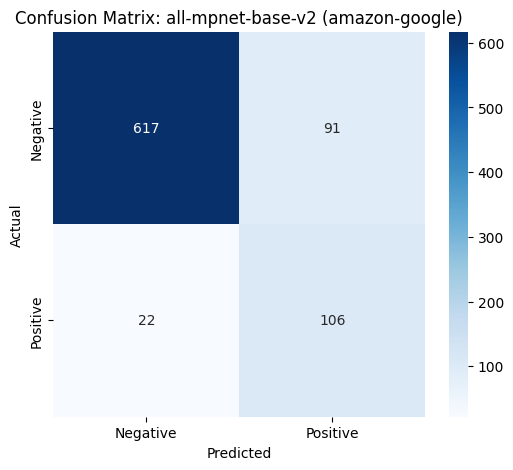

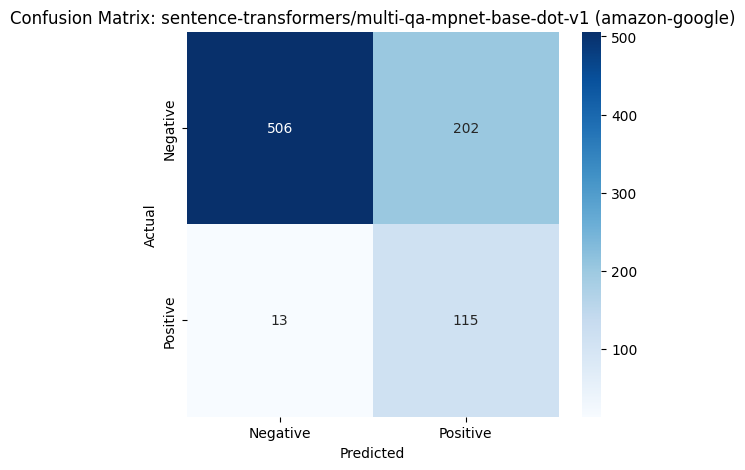

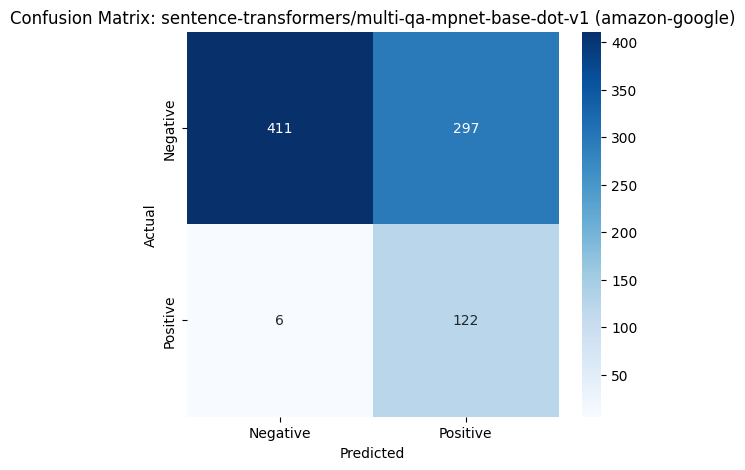

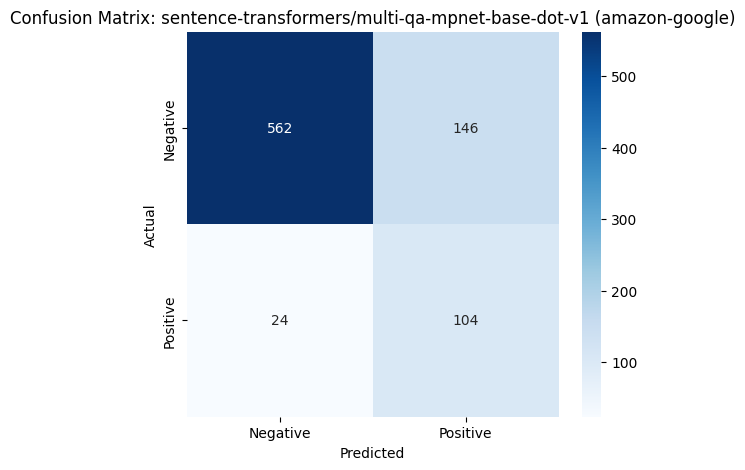

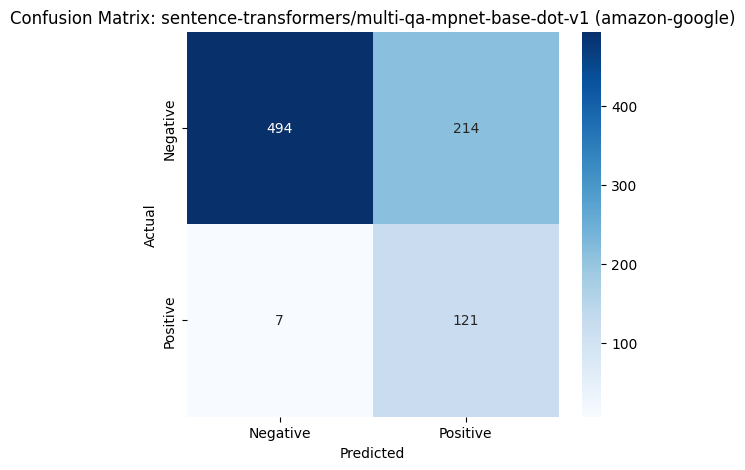

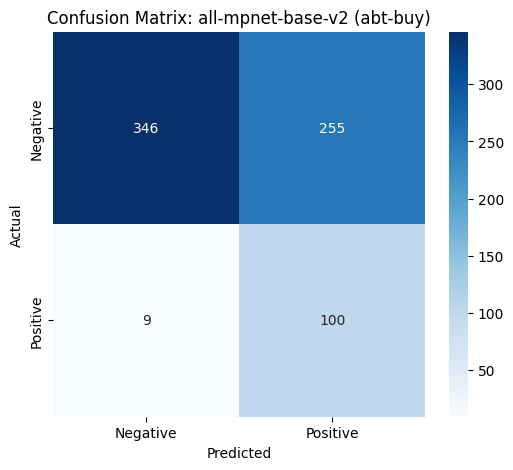

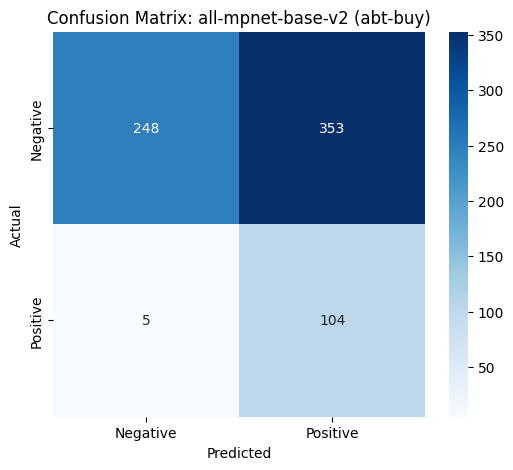

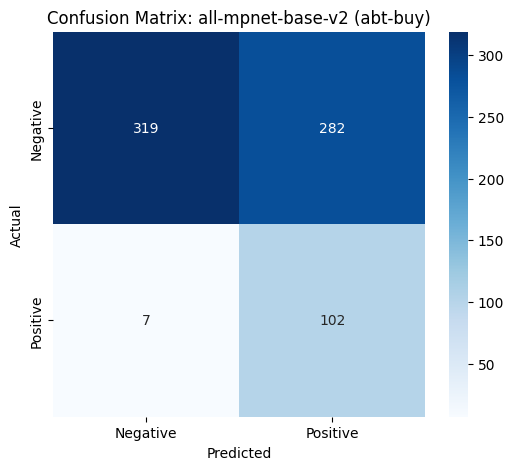

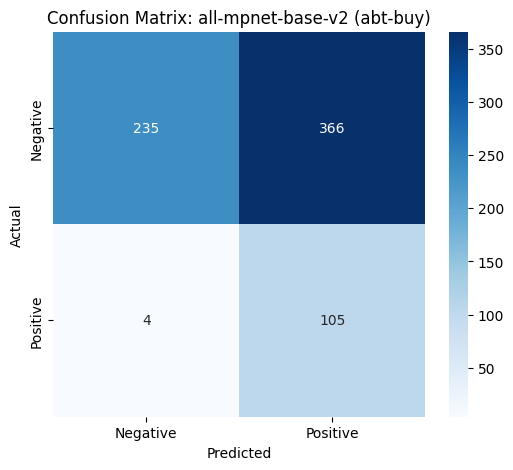

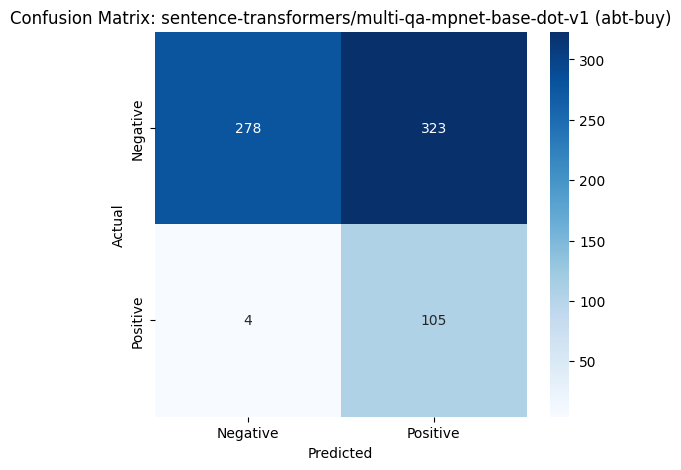

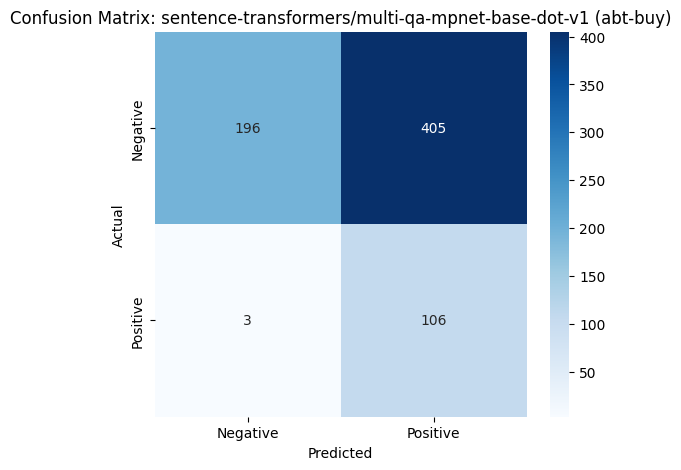

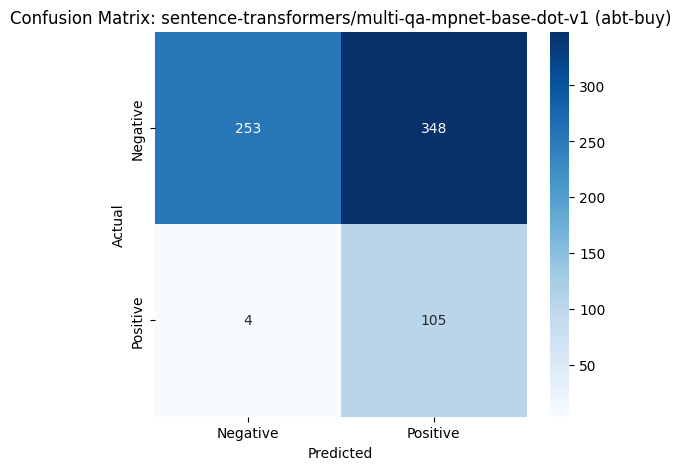

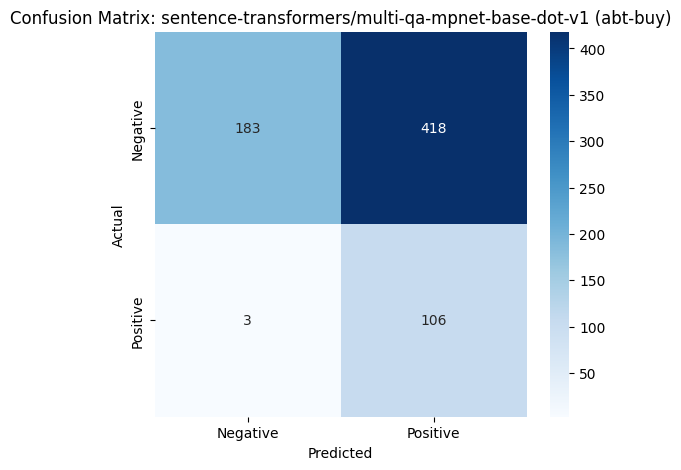

In [8]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

for data_name, models in results_dict.items():
    for model_name, orders in models.items():
        for order_cols, removes in orders.items():
            for remove_col_names, metrics in removes.items():
                cm = np.array(metrics["confusion_matrix"])
                plt.figure(figsize=(6, 5))
                sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
                plt.xlabel("Predicted")
                plt.ylabel("Actual")
                plt.title(f"Confusion Matrix: {model_name} ({data_name})")
                plt.show()

### 3. ROC Curve for Classification Models

<Figure size 1000x600 with 0 Axes>

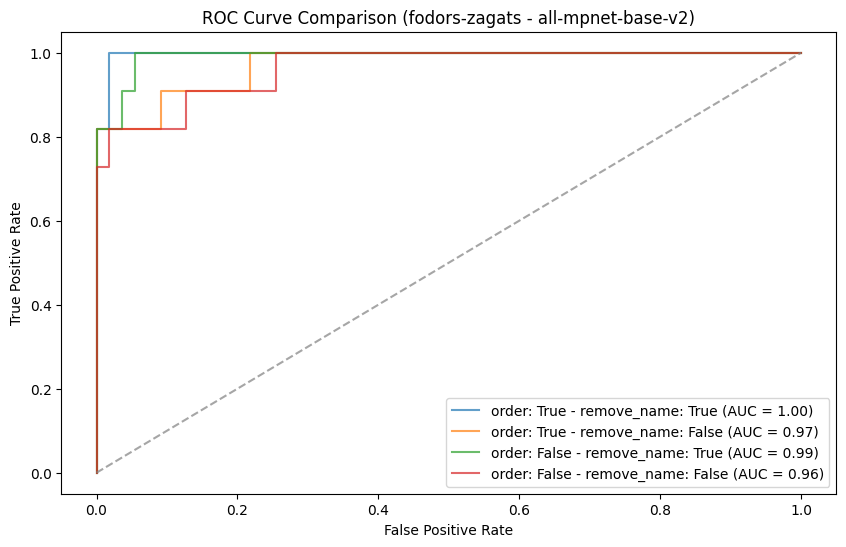

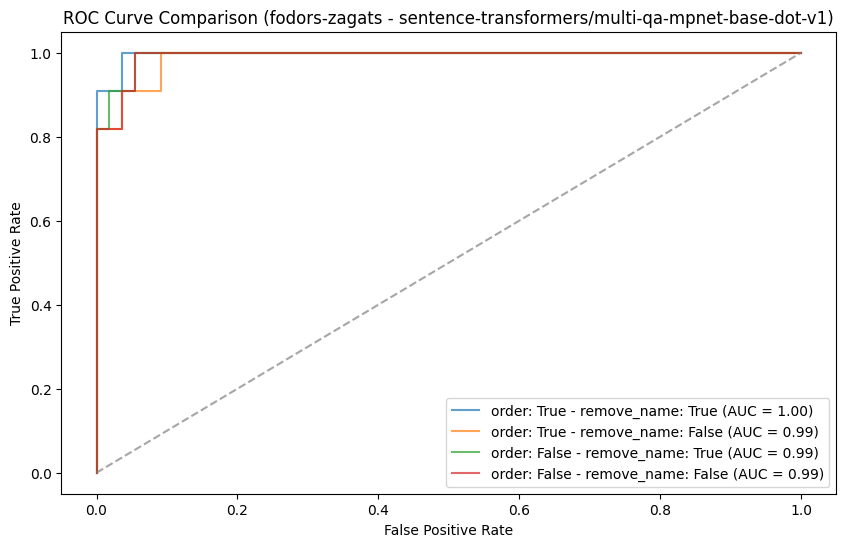

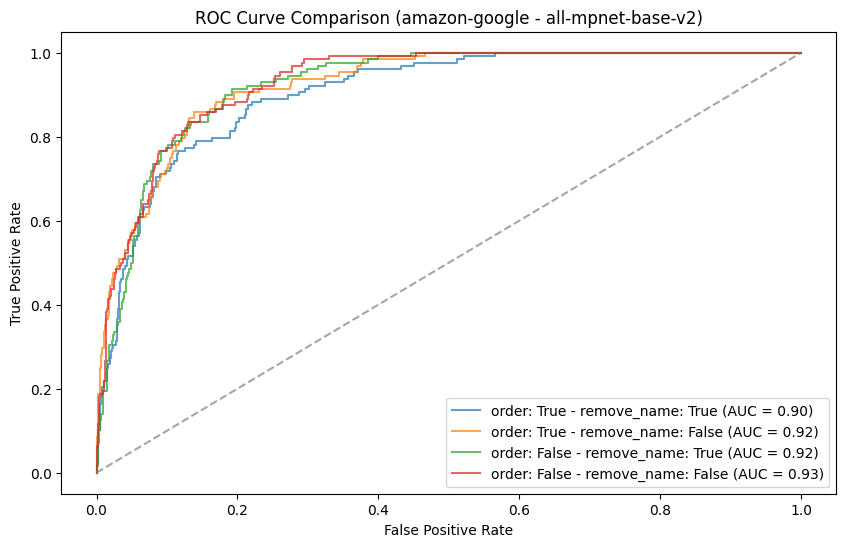

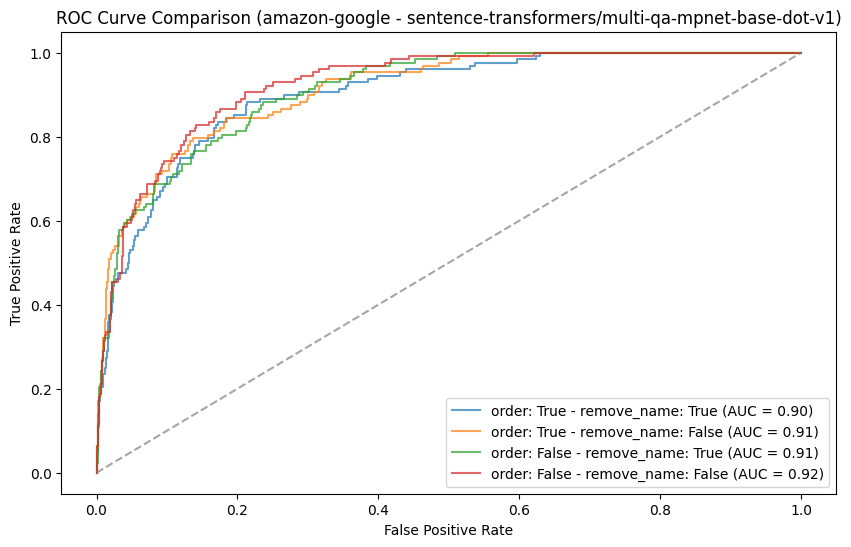

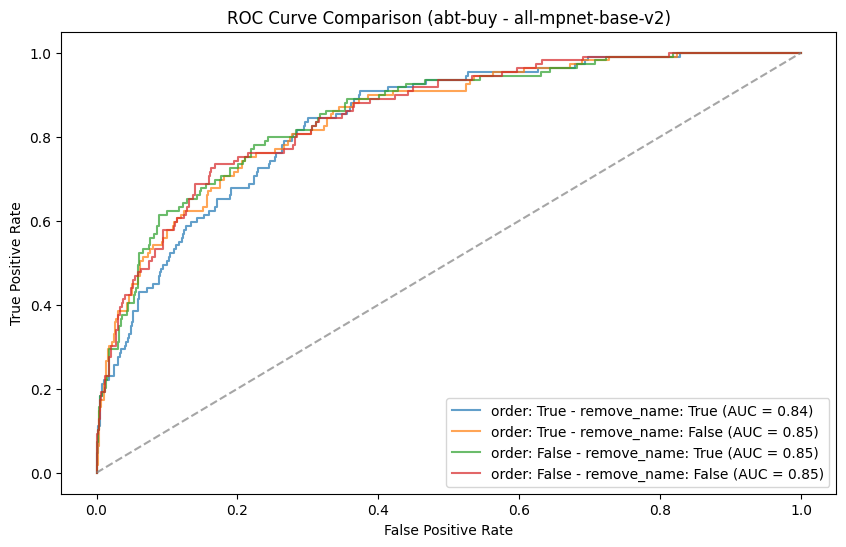

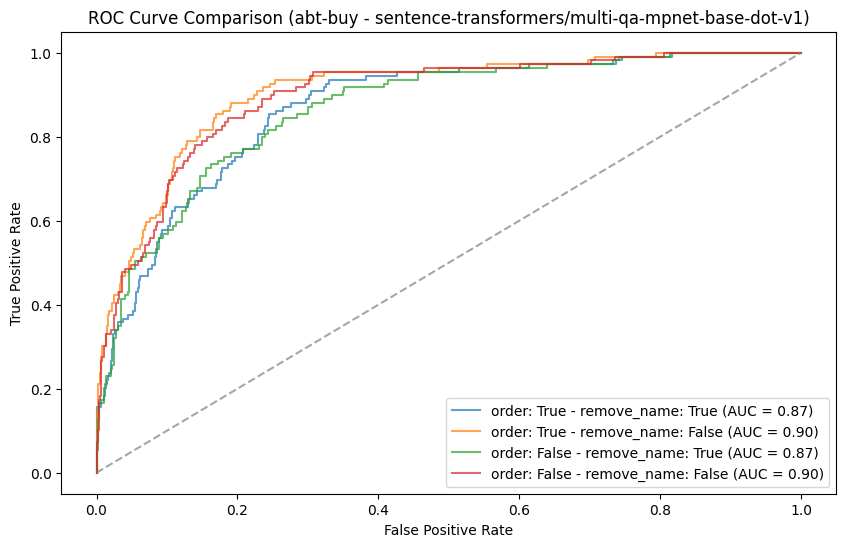

In [9]:
from sklearn.metrics import roc_curve, auc

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

plt.figure(figsize=(10, 6))

for data_name, models in results_dict.items():
    for model_name, orders in models.items():
        plt.figure(figsize=(10, 6))
        for order_cols, removes in orders.items():
            for remove_col_names, metrics in removes.items():
                fpr, tpr, auc_score = metrics["roc_curve"]
                plt.plot(fpr, tpr, label=f"order: {order_cols} - remove_name: {remove_col_names} (AUC = {auc_score:.2f})", alpha=0.7)

        plt.plot([0, 1], [0, 1], linestyle="--", color="gray", alpha=0.7)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve Comparison ({data_name} - {model_name})")
        plt.legend()
        plt.show()

### 4. Table of Metrics

In [10]:
import pandas as pd

all_results = []

for data_name, models in results_dict.items():
    for model_name, orders in models.items():
        for order_cols, removes in orders.items():
            for remove_col_names, metrics in removes.items():
                all_results.append([
                    data_name, model_name, order_cols, remove_col_names,
                    metrics["precision"], metrics["recall"], metrics["f1"],
                    metrics["roc_auc"], metrics["accuracy"]
                ])

df_results = pd.DataFrame(all_results, columns=["Dataset", "Model", "Order Cols", "Remove Cols",
                                                 "Precision", "Recall", "F1", "ROC AUC", "Accuracy"])

df_results

Dataset                                             Model  \
0   fodors-zagats                                 all-mpnet-base-v2   
1   fodors-zagats                                 all-mpnet-base-v2   
2   fodors-zagats                                 all-mpnet-base-v2   
3   fodors-zagats                                 all-mpnet-base-v2   
4   fodors-zagats  sentence-transformers/multi-qa-mpnet-base-dot-v1   
5   fodors-zagats  sentence-transformers/multi-qa-mpnet-base-dot-v1   
6   fodors-zagats  sentence-transformers/multi-qa-mpnet-base-dot-v1   
7   fodors-zagats  sentence-transformers/multi-qa-mpnet-base-dot-v1   
8   amazon-google                                 all-mpnet-base-v2   
9   amazon-google                                 all-mpnet-base-v2   
10  amazon-google                                 all-mpnet-base-v2   
11  amazon-google                                 all-mpnet-base-v2   
12  amazon-google  sentence-transformers/multi-qa-mpnet-base-dot-v1   
13  amazon-google  sentence-transformers/multi-qa-mpnet-base-dot-v1   
14  amazon-google  sentence-transformers/multi-qa-mpnet-base-dot-v1   
15  amazon-google  sentence-transformers/multi-qa-mpnet-base-dot-v1   
16        abt-buy                                 all-mpnet-base-v2   
17        abt-buy                                 all-mpnet-base-v2   
18        abt-buy                                 all-mpnet-base-v2   
19        abt-buy                                 all-mpnet-base-v2   
20        abt-buy  sentence-transformers/multi-qa-mpnet-base-dot-v1   
21        abt-buy  sentence-transformers/multi-qa-mpnet-base-dot-v1   
22        abt-buy  sentence-transformers/multi-qa-mpnet-base-dot-v1   
23        abt-buy  sentence-transformers/multi-qa-mpnet-base-dot-v1   

    Order Cols  Remove Cols  Precision    Recall        F1   ROC AUC  Accuracy  
0         True         True   0.423077  1.000000  0.594595  0.996694  0.772727  
1         True        False   0.220000  1.000000  0.360656  0.971901  0.409091  
2        False         True   0.407407  1.000000  0.578947  0.991736  0.757576  
3        False        False   0.207547  1.000000  0.343750  0.963636  0.363636  
4         True         True   0.297297  1.000000  0.458333  0.996694  0.606061  
5         True        False   0.171875  1.000000  0.293333  0.988430  0.196970  
6        False         True   0.305556  1.000000  0.468085  0.993388  0.621212  
7        False        False   0.171875  1.000000  0.293333  0.991736  0.196970  
8         True         True   0.487923  0.789062  0.602985  0.904882  0.840909  
9         True        False   0.526829  0.843750  0.648649  0.923630  0.860048  
10       False         True   0.530303  0.820312  0.644172  0.923530  0.861244  
11       False        False   0.538071  0.828125  0.652308  0.929125  0.864833  
12        True         True   0.362776  0.898438  0.516854  0.900424  0.742823  
13        True        False   0.291169  0.953125  0.446069  0.910642  0.637560  
14       False         True   0.416000  0.812500  0.550265  0.909174  0.796651  
15       False        False   0.361194  0.945312  0.522678  0.922272  0.735646  
16        True         True   0.281690  0.917431  0.431034  0.838740  0.628169  
17        True        False   0.227571  0.954128  0.367491  0.848311  0.495775  
18       False         True   0.265625  0.935780  0.413793  0.854478  0.592958  
19       False        False   0.222930  0.963303  0.362069  0.852631  0.478873  
20        True         True   0.245327  0.963303  0.391061  0.868827  0.539437  
21        True        False   0.207436  0.972477  0.341935  0.904670  0.425352  
22       False         True   0.231788  0.963303  0.373665  0.865912  0.504225  
23       False        False   0.202290  0.972477  0.334913  0.895724  0.407042

### 5. Impact of the threshold on the metrics

Table A columns:
  column_name              data_example
1        addr  '435 s. la cienega blv.'
2        city             'los angeles'
3       phone              310/246-1501
4        type                  american 

Table B columns:
  column_name           data_example
1        addr  '10801 w. pico blvd.'
2        city              'west la'
3       phone           310-475-3585
4        type               american 

Serialized entities 



/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


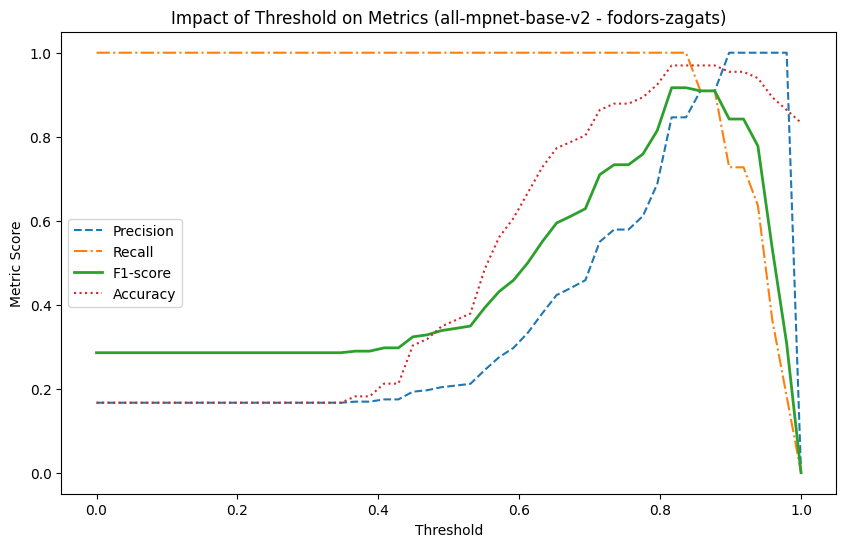

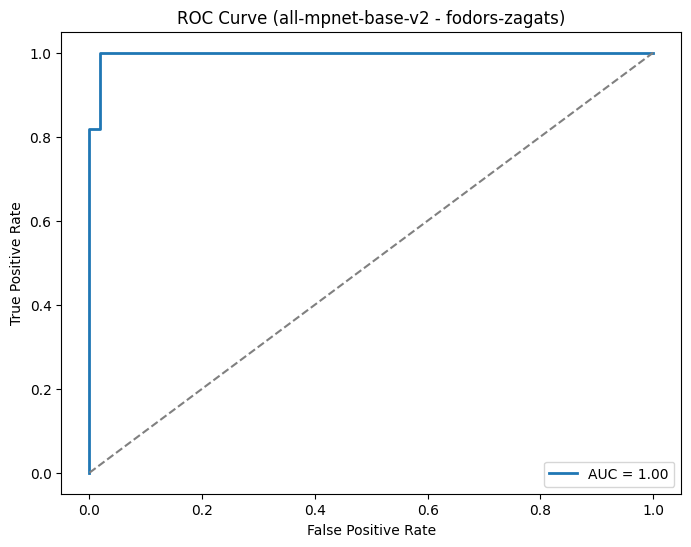

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


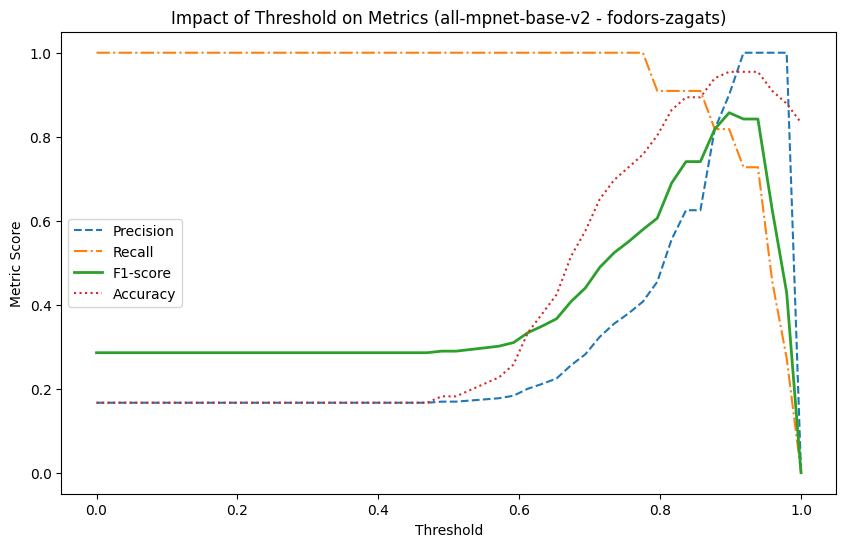

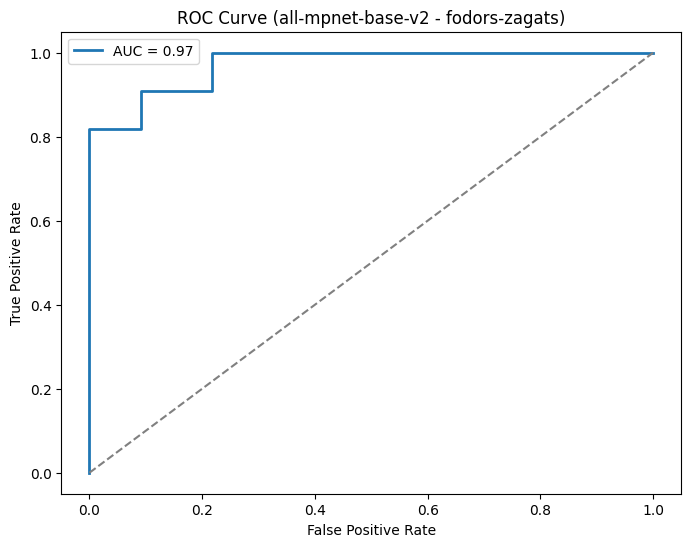

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


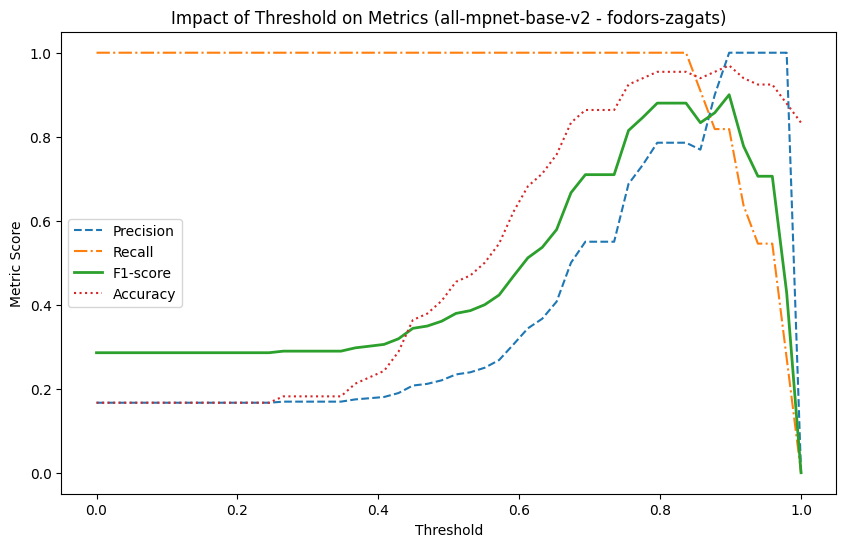

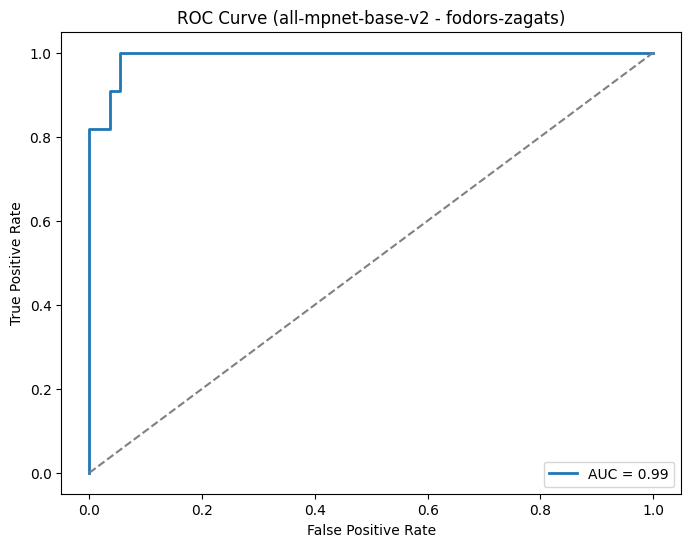

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


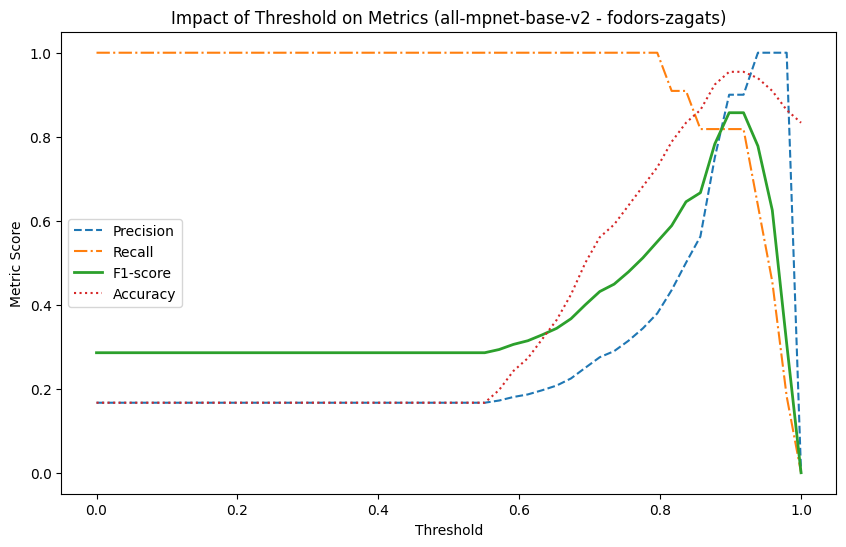

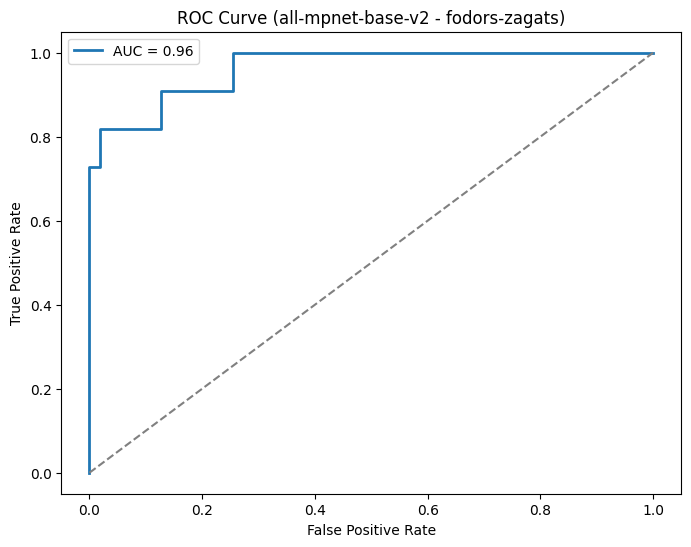

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


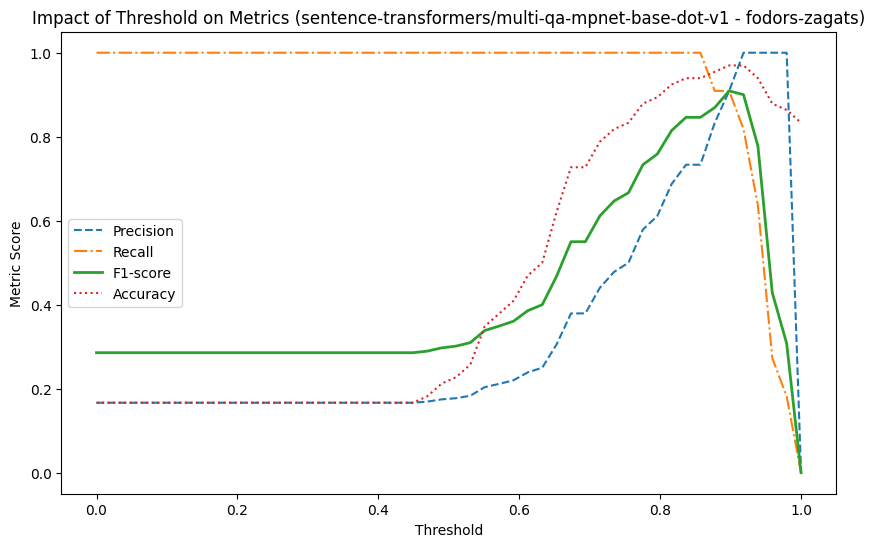

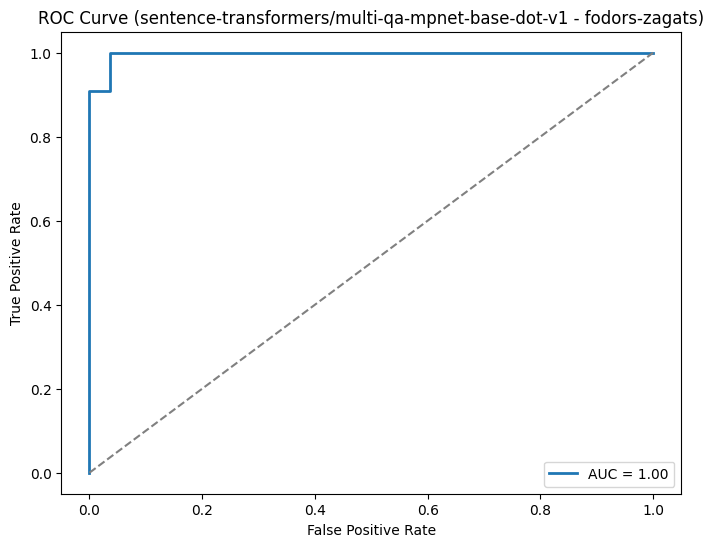

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


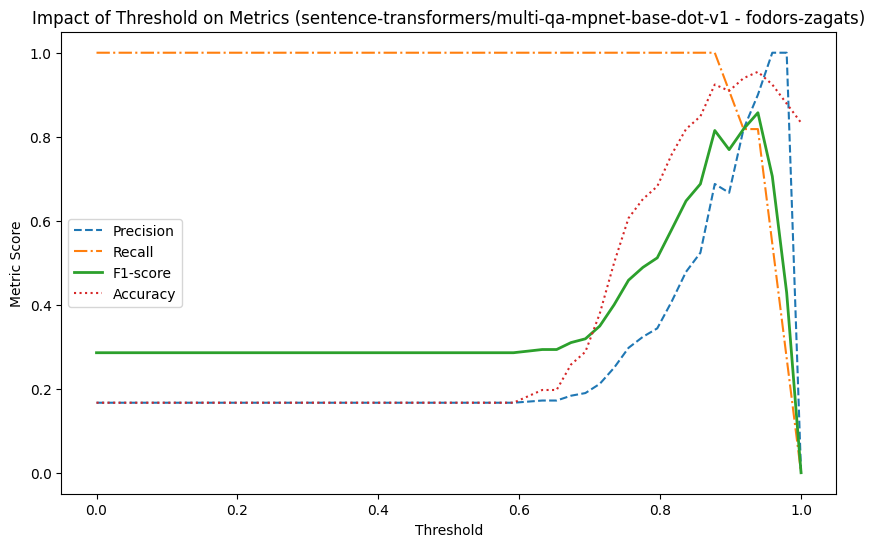

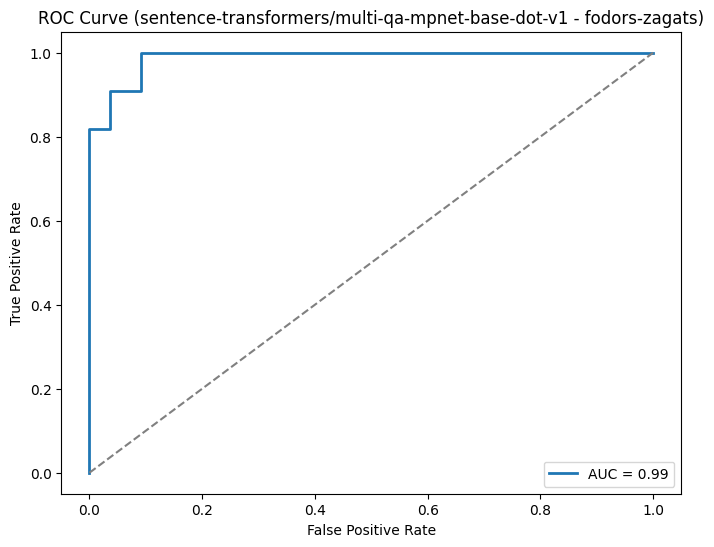

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


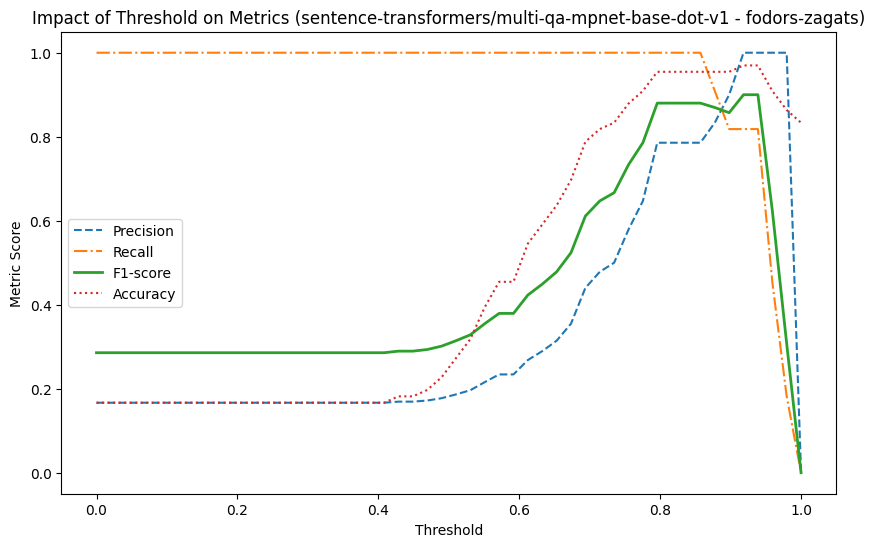

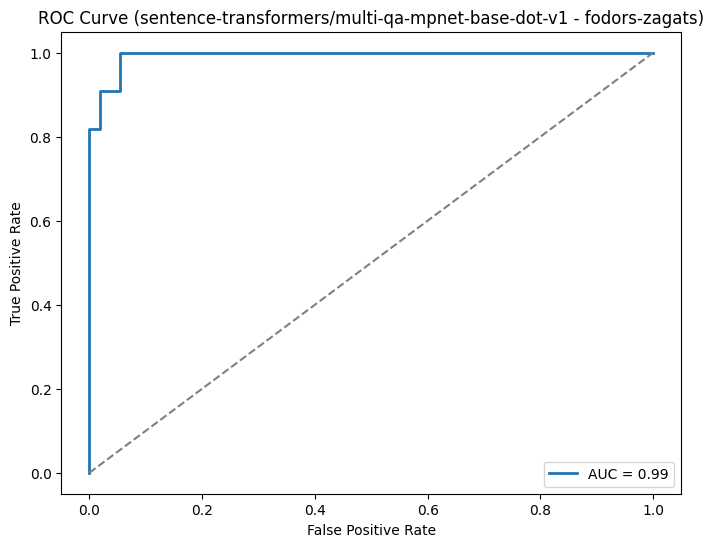

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


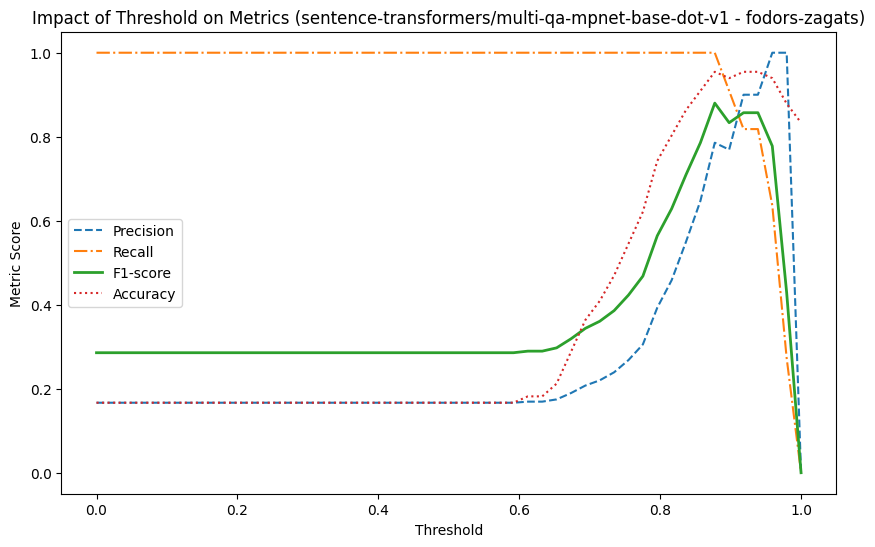

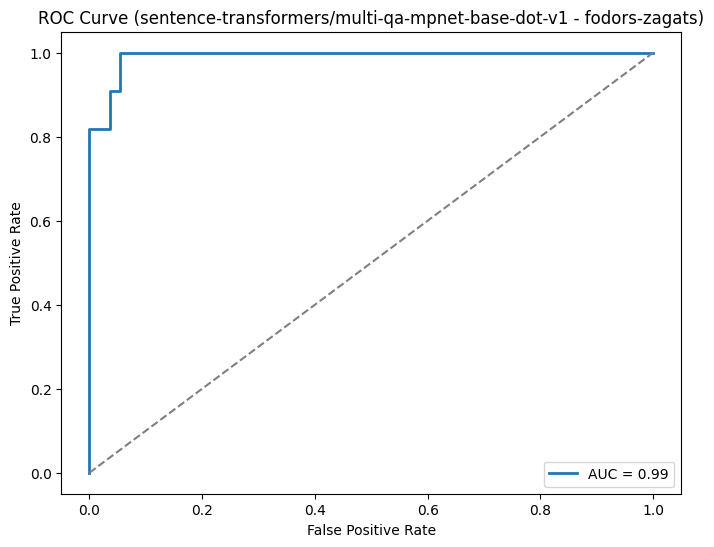

Table A columns:
    column_name data_example
1   description          NaN
2  manufacturer   broderbund
3         price          0.0 

Table B columns:
    column_name              data_example
1   description  learning quickbooks 2007
2  manufacturer                    intuit
3         price                     38.99 

Serialized entities 



/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

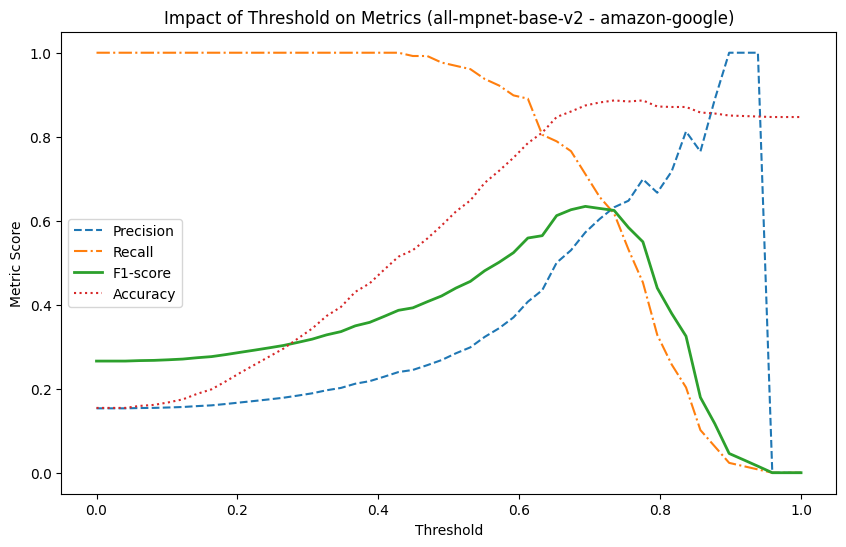

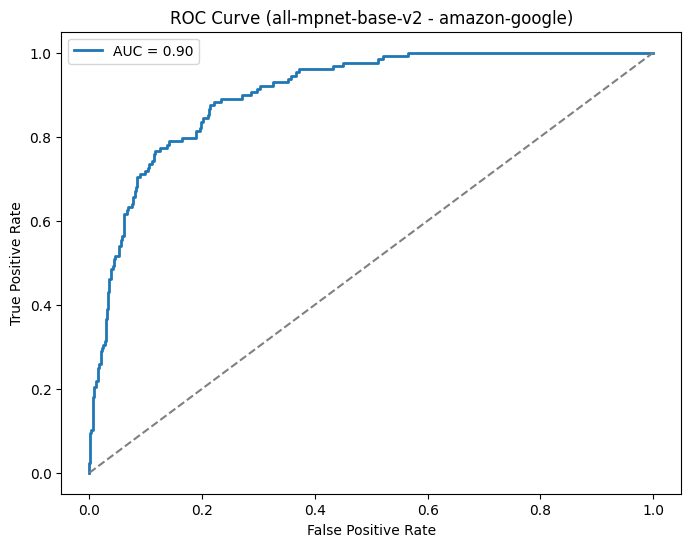

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

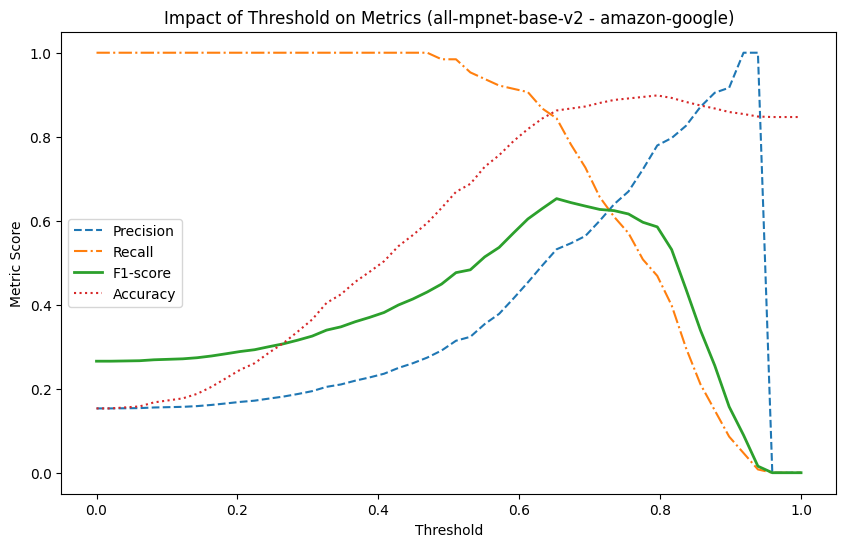

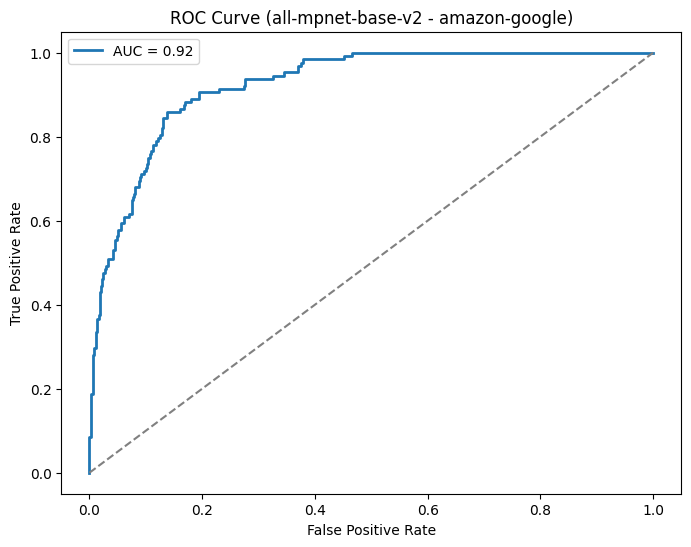

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

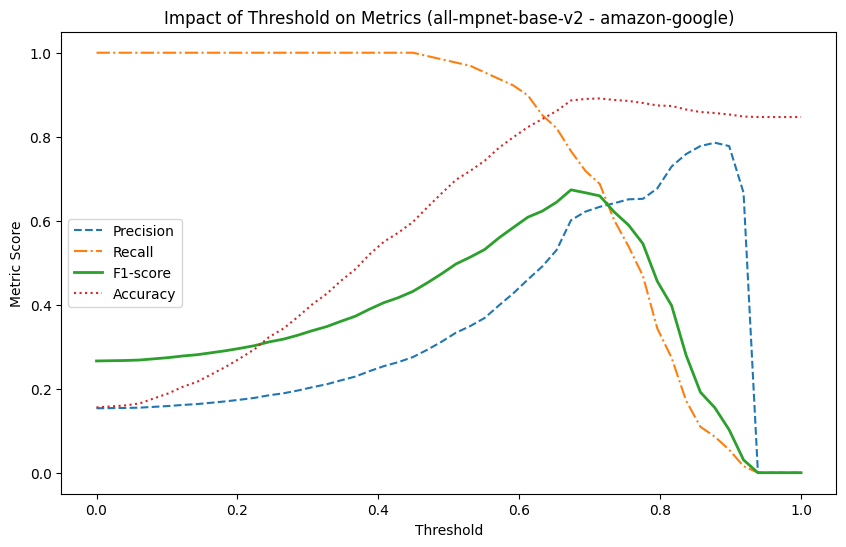

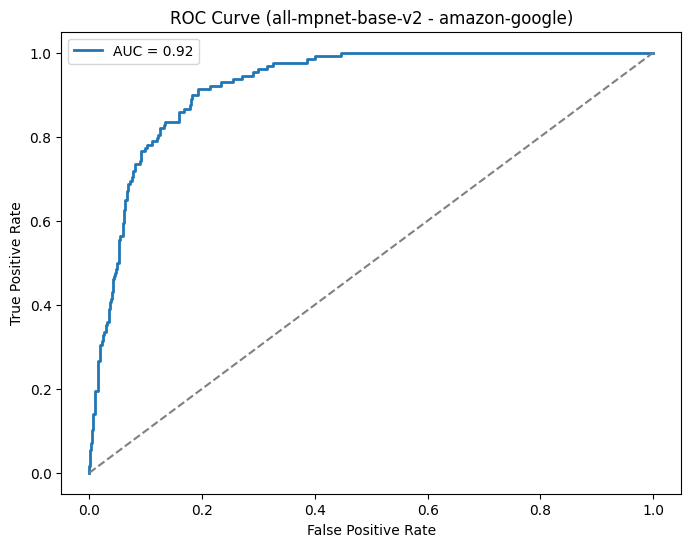

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

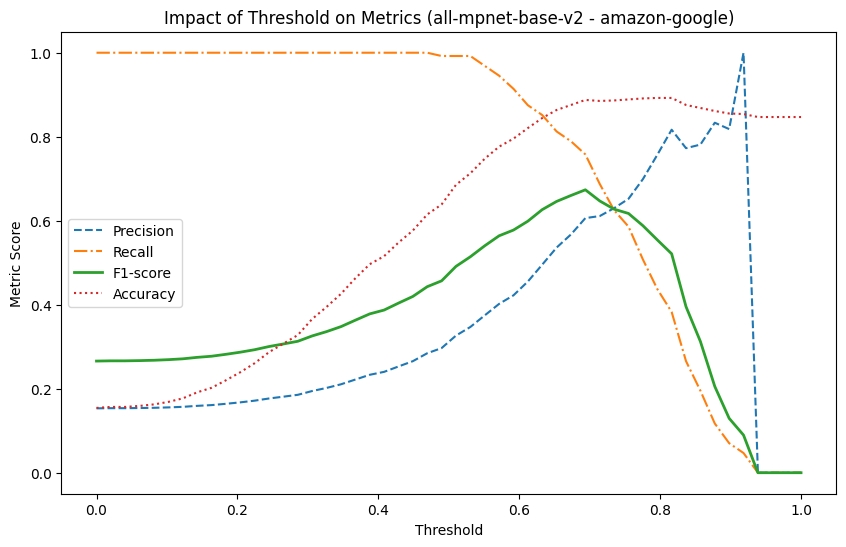

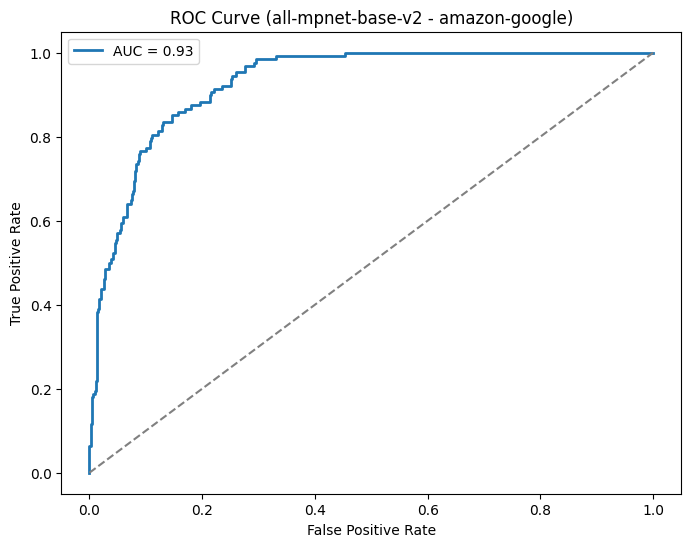

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

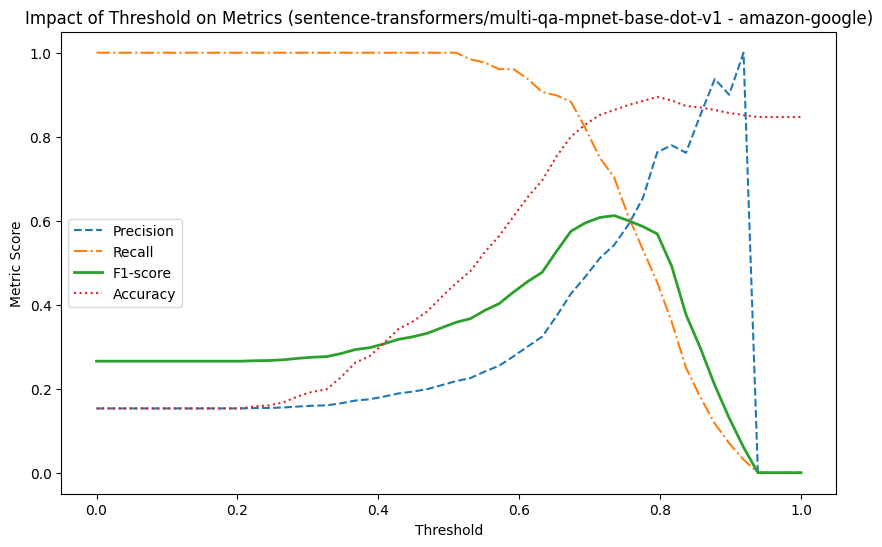

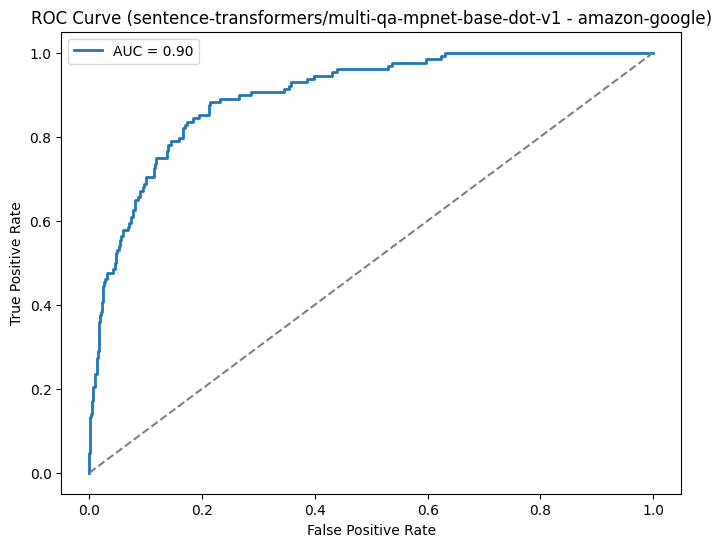

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


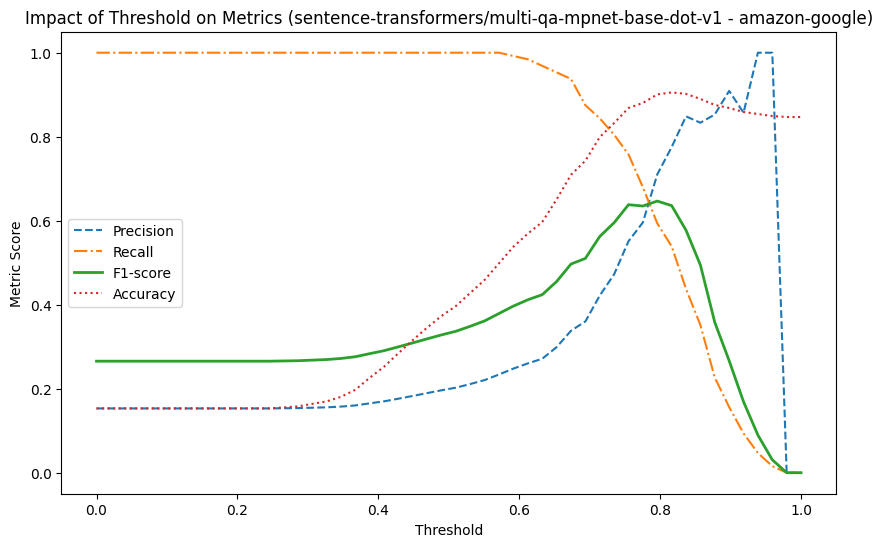

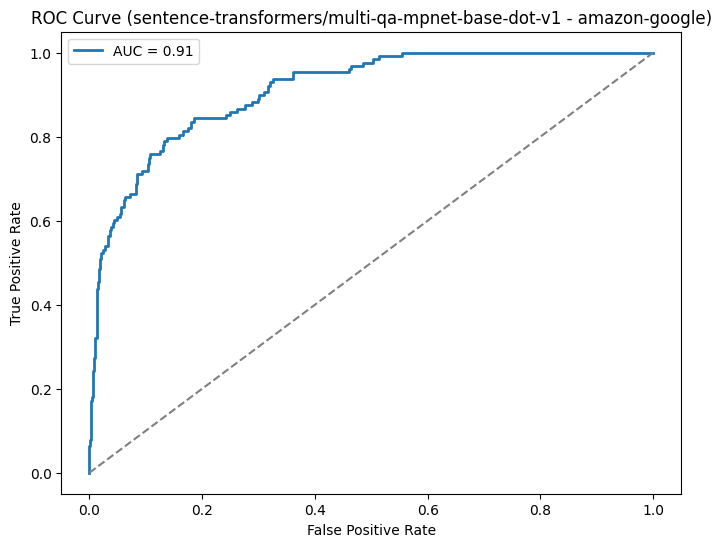

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

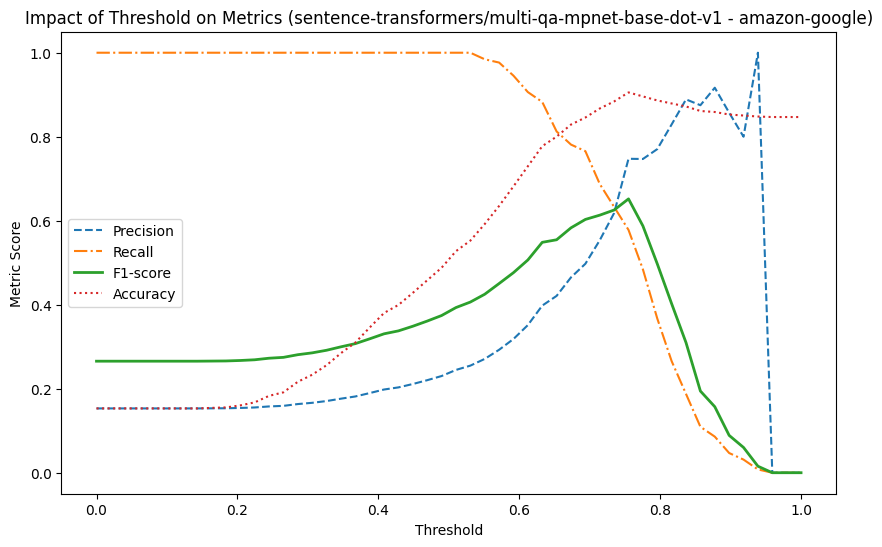

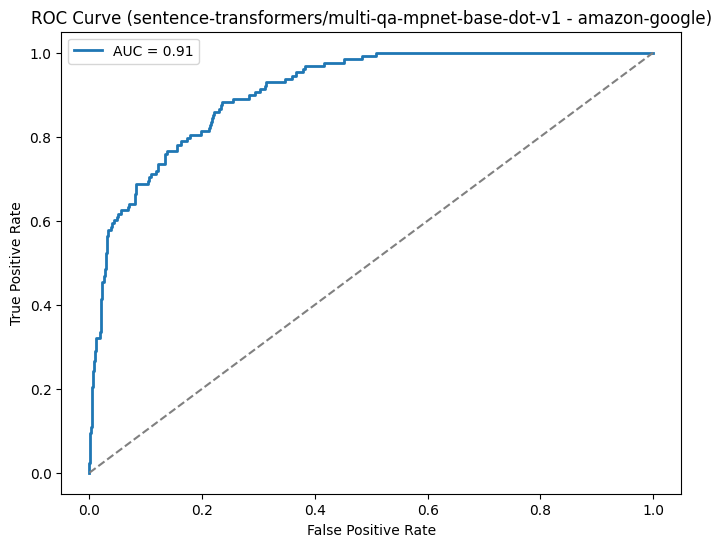

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


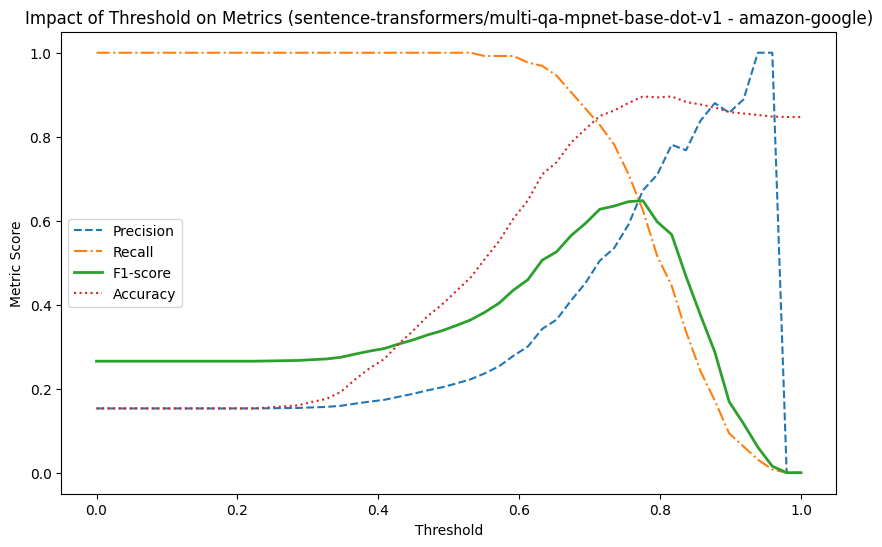

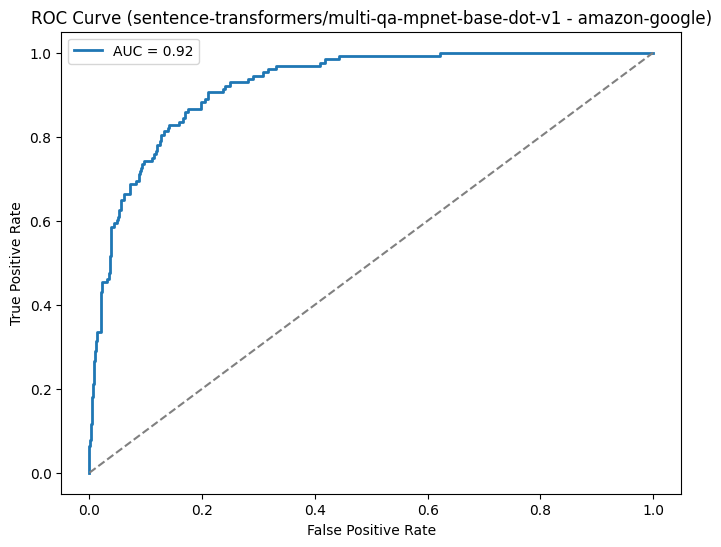

Table A columns:
   column_name                                       data_example
1  description  Sony Turntable - PSLX350H/ Belt Drive System/ ...
2        price                                                NaN 

Table B columns:
    column_name                                       data_example
1   description  Linksys EtherFast 8-Port 10/100 Switch (New/Wo...
2  manufacturer                                            LINKSYS
3         price                                                NaN 

Columns are not the same in both tables
Table A columns: ['name' 'description' 'price']
Table B columns: ['name' 'description' 'manufacturer' 'price']
Serialized entities 



/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

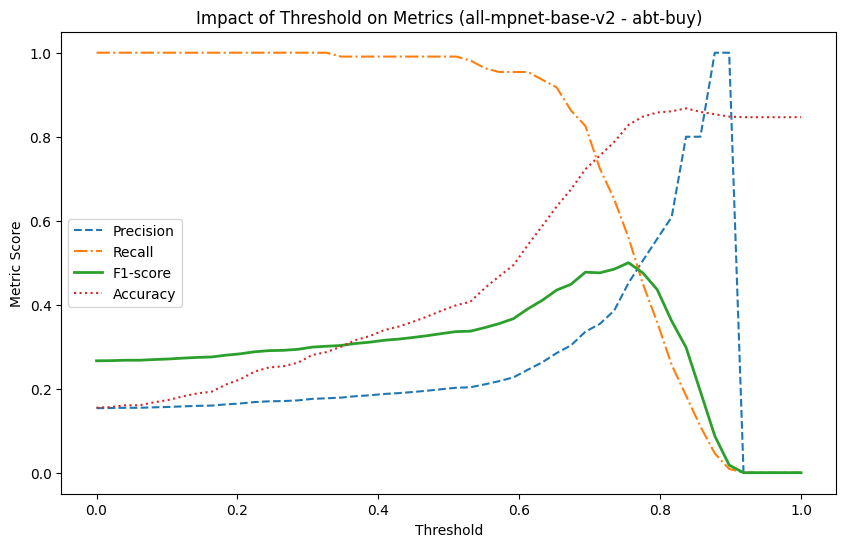

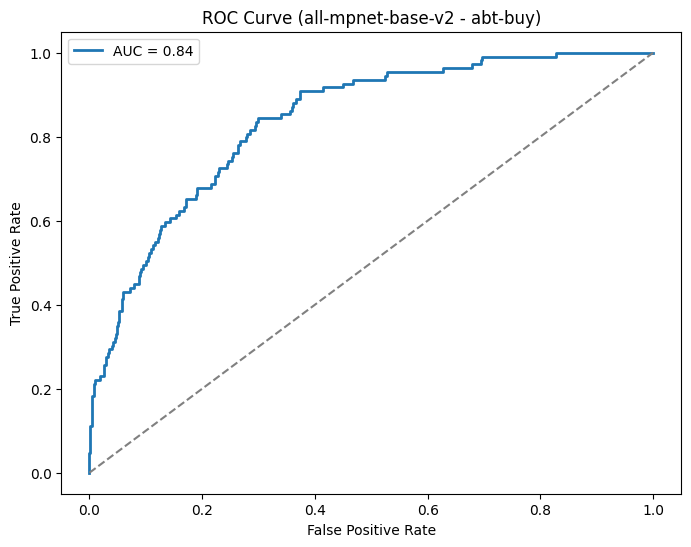

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

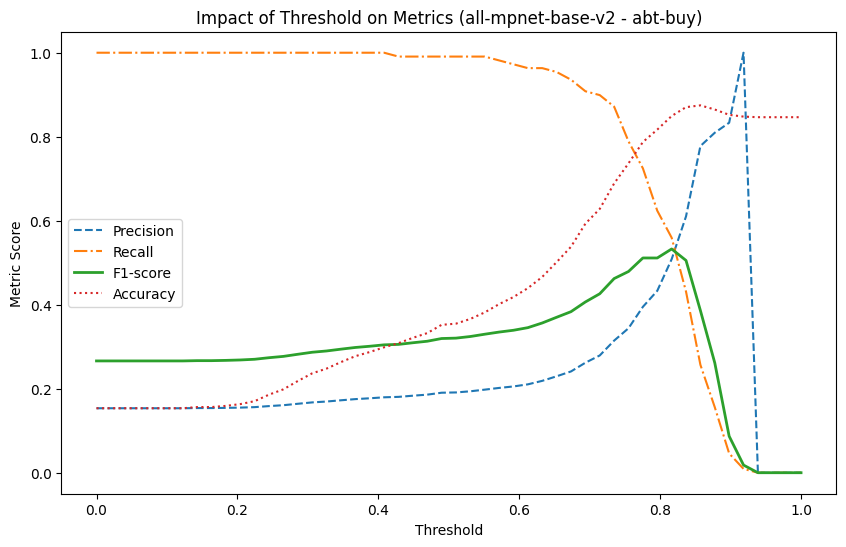

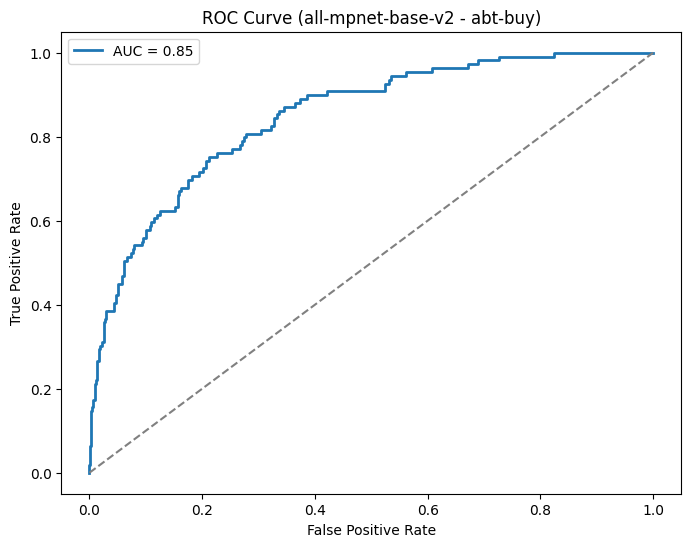

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

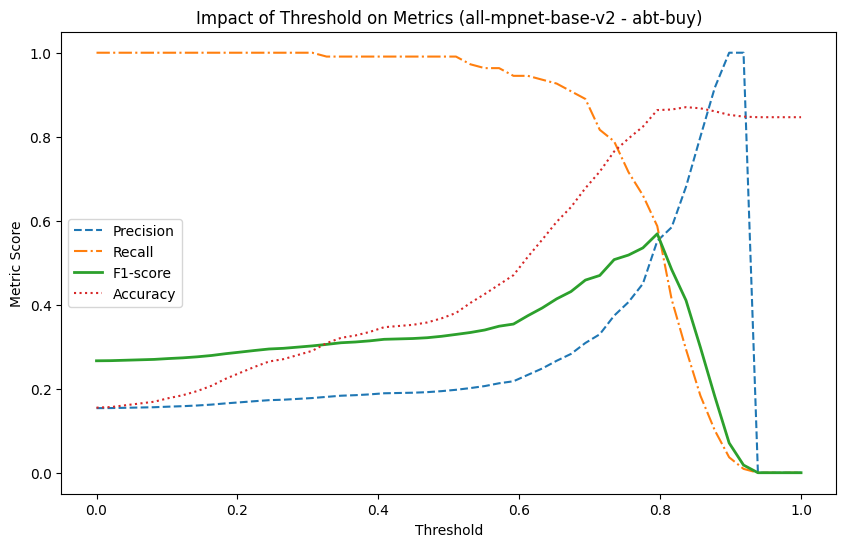

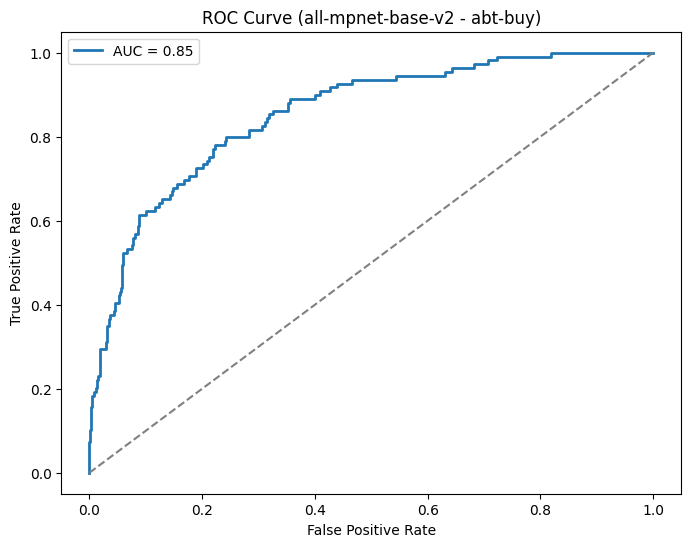

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

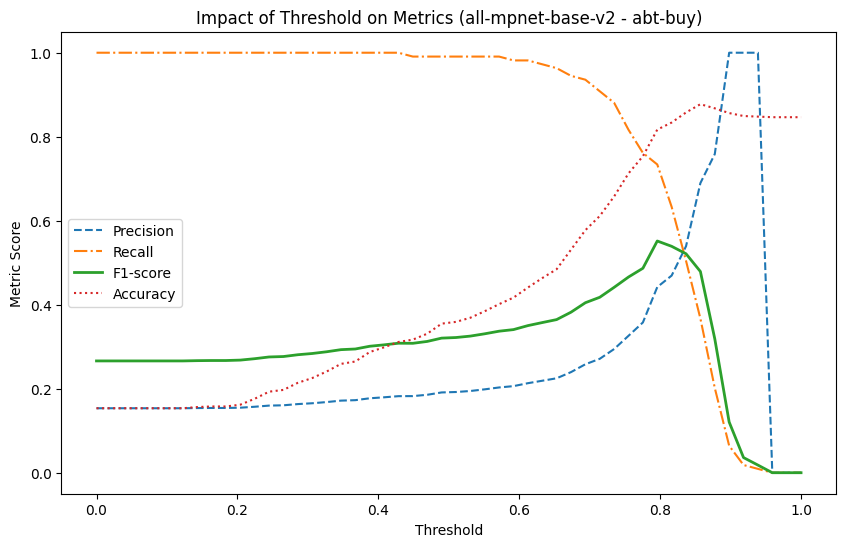

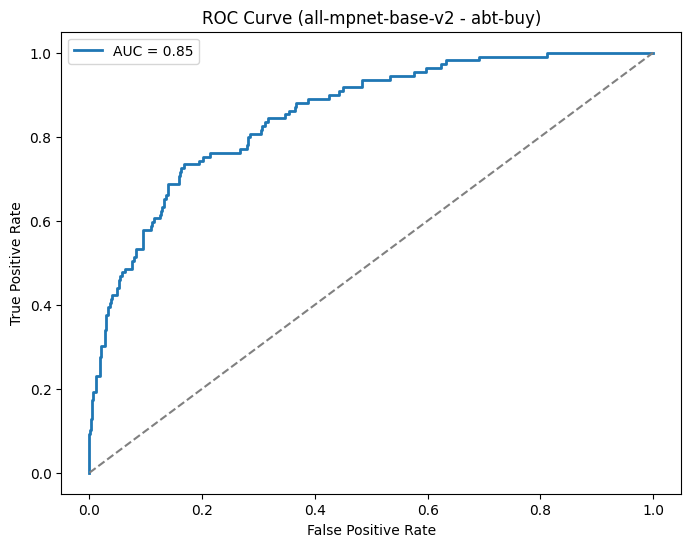

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

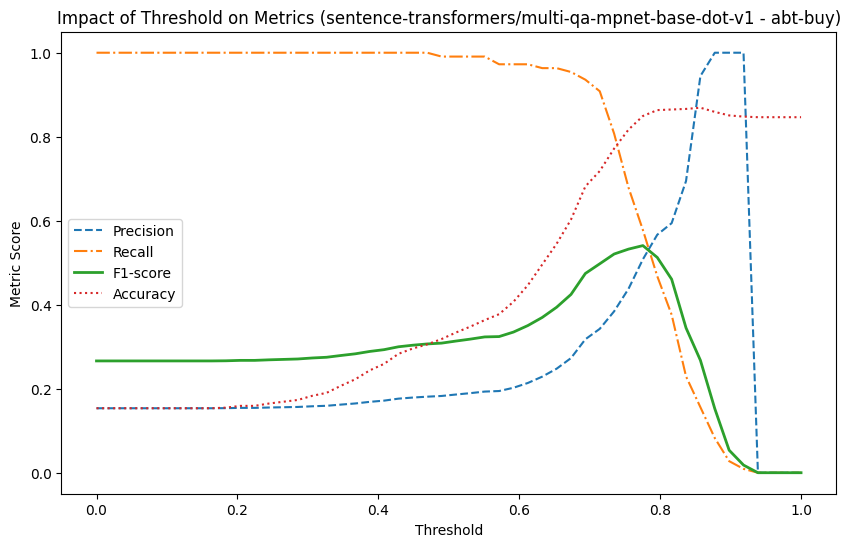

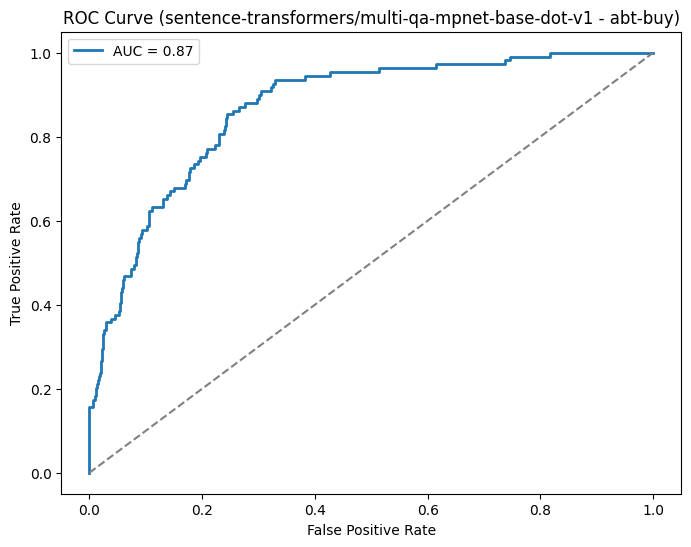

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

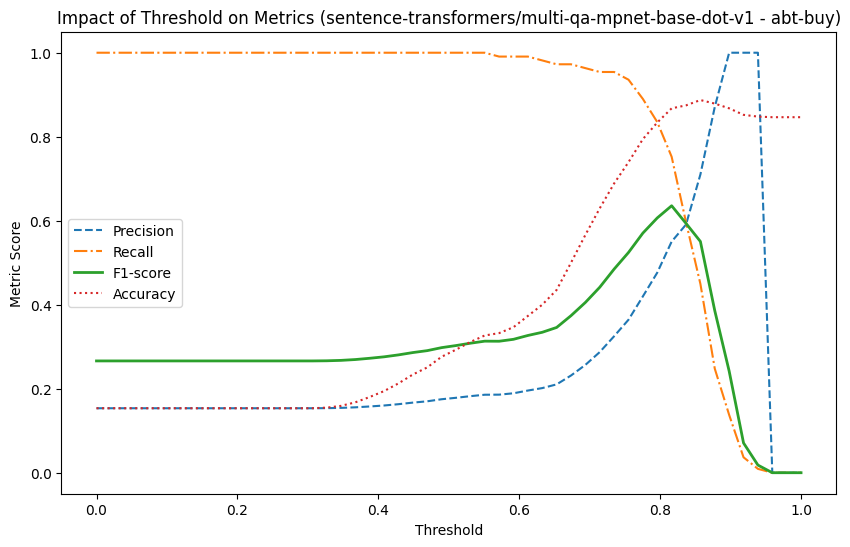

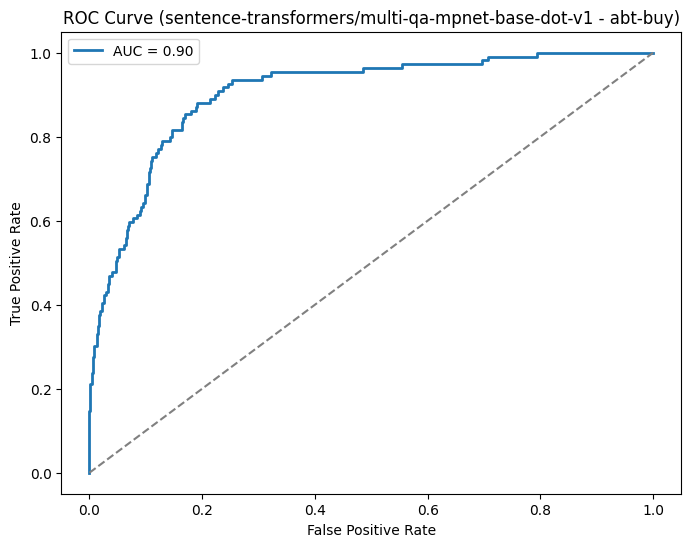

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

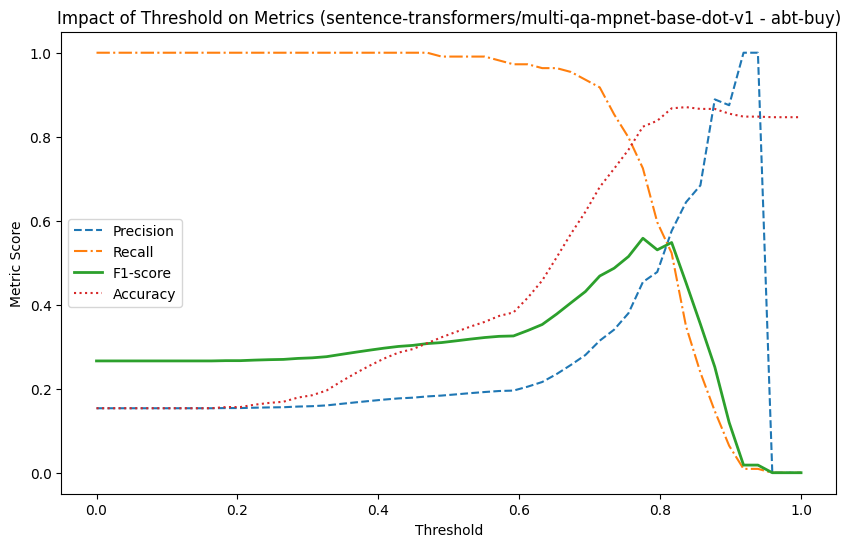

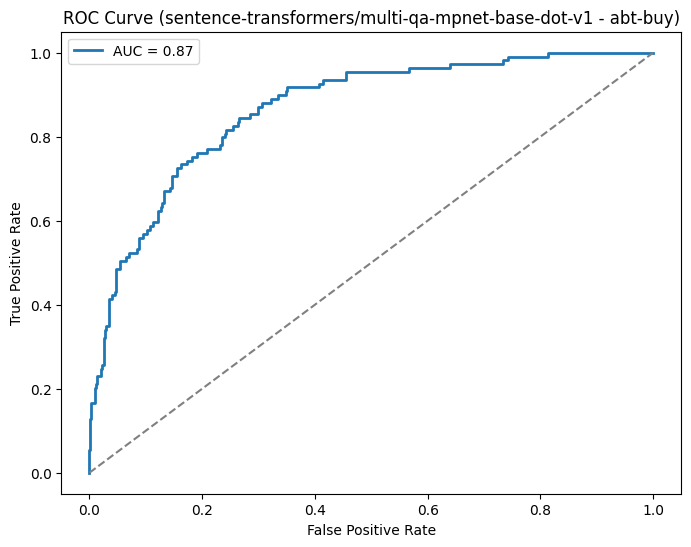

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

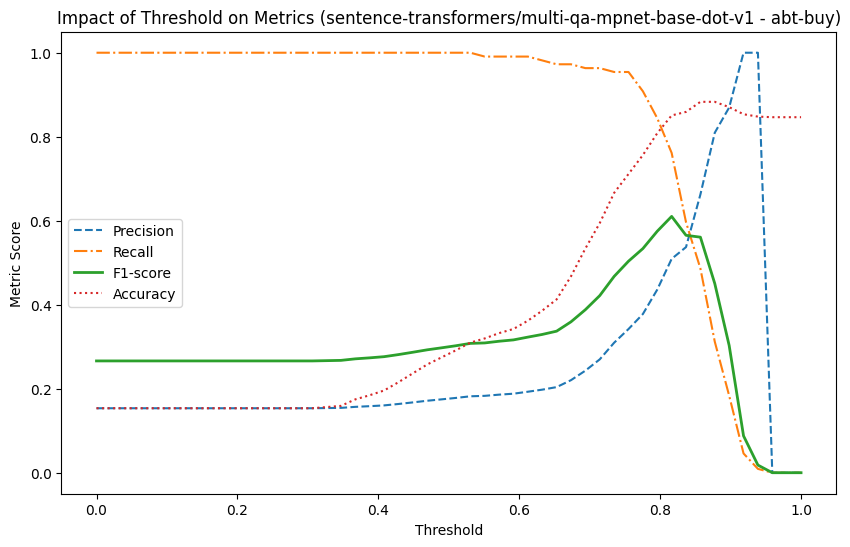

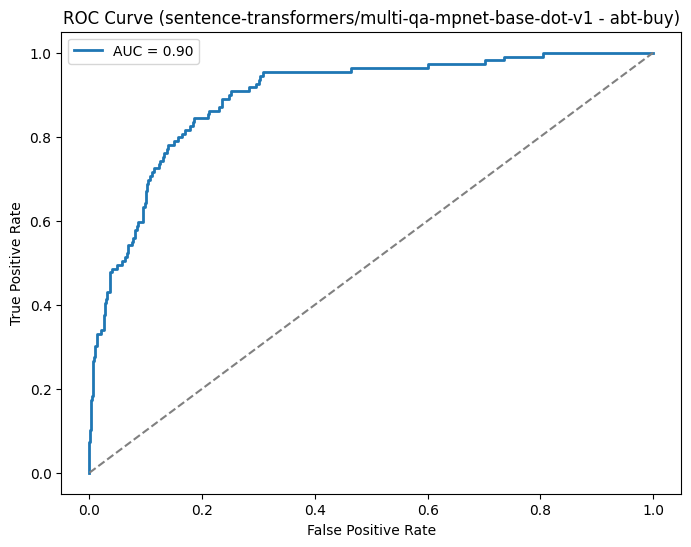

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc

# Store results for plotting
thresholds = np.linspace(0, 1, 50)  # 50 different thresholds from 0 to 1

metrics_results = {}

# Loop through models and datasets
for data_name, models in results_dict.items():
    table_a_serialized, table_b_serialized, X_train_ids, y_train, X_valid_ids, y_valid, X_test_ids, y_test = load_data(os.path.join(import_data.DATA_FOLDER, data_name))
    for model_name, orders in models.items():
        for order_cols, removes in orders.items():
            for remove_col_names, metrics in removes.items():
                y_probs = np.array(metrics["logits"]["pred"])

                precisions, recalls, f1s, accuracies = [], [], [], []

                for thresh in thresholds:
                    y_pred = (y_probs >= thresh).astype(int)

                    precisions.append(precision_score(y_test, y_pred))
                    recalls.append(recall_score(y_test, y_pred))
                    f1s.append(f1_score(y_test, y_pred))
                    accuracies.append(accuracy_score(y_test, y_pred))

                # Plot results
                fig, ax = plt.subplots(figsize=(10, 6))
                ax.plot(thresholds, precisions, label="Precision", linestyle="--")
                ax.plot(thresholds, recalls, label="Recall", linestyle="-.")
                ax.plot(thresholds, f1s, label="F1-score", linewidth=2)
                ax.plot(thresholds, accuracies, label="Accuracy", linestyle="dotted")

                ax.set_xlabel("Threshold")
                ax.set_ylabel("Metric Score")
                ax.set_title(f"Impact of Threshold on Metrics ({model_name} - {data_name})")
                ax.legend()
                plt.show()

                # ROC Curve
                fpr, tpr, _ = roc_curve(y_test, y_probs)
                auc_score = auc(fpr, tpr)

                plt.figure(figsize=(8, 6))
                plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}", linewidth=2)
                plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line
                plt.xlabel("False Positive Rate")
                plt.ylabel("True Positive Rate")
                plt.title(f"ROC Curve ({model_name} - {data_name})")
                plt.legend()
                plt.show()